In [1]:
from pathlib import Path
from collections import defaultdict
from itertools import product
from time import perf_counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from tqdm.notebook import tqdm
import cvxpy as cp
import utils
import design
import main_gaussian


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [2]:
from importlib import reload
reload(main_gaussian)

<module 'main_gaussian' from '/u/luchar/data-markets/main_gaussian.py'>

In [3]:
V = design.Valuator()

In [4]:
def get_error(x_b, y_b, x_s, y_s, w, k=10):
    s = w.argsort()[::-1][:k]
    x_k = x_s[s]
    y_k = y_s[s]
    beta_k = np.linalg.pinv(x_k) @ y_k
    y_hat = x_b @ beta_k
    return (y_hat - y_b)**2

In [5]:
data = utils.get_gaussian_data(num=1000, dim=100, noise=0.5)

x = data['X']
y = data['y']
coef = data['coef']

In [13]:
reload(main_gaussian)
num_trials = 10
num_buy = 5
rang = list(range(2, 20)) + list(range(20, 120, 5))

err_cvx = []
err_fw = []
err_rand = []

for j in range(0, num_trials):
    x_b = x[j + num_buy, None]
    # y_b = y[j, None]
    y_b = x_b @ coef
    x_s = np.concatenate([x[:j], x[j + num_buy + 1:]])
    y_s = np.concatenate([y[:j], y[j + num_buy + 1:]])
    
    
    res_fw = main_gaussian.design_selection( 
        (x_s, y_s), (x_b, y_b),  
        num_select=10,
        num_iters=100,
        alpha=0.1,
        recompute_interval=0,
        line_search=True,
    )
    w_fw = res_fw['weights']
    
    # w_cvx = V.optimize(x_b, x_s)
    
    w_rand = np.random.permutation(len(x_s))
    # err_cvx.append([get_error(x_b, y_b, x_s, y_s, w_cvx, k) for k in rang])
    err_fw.append([get_error(x_b, y_b, x_s, y_s, w_fw, k) for k in rang])
    err_rand.append([get_error(x_b, y_b, x_s, y_s, w_rand, k) for k in rang])

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 366.71it/s]


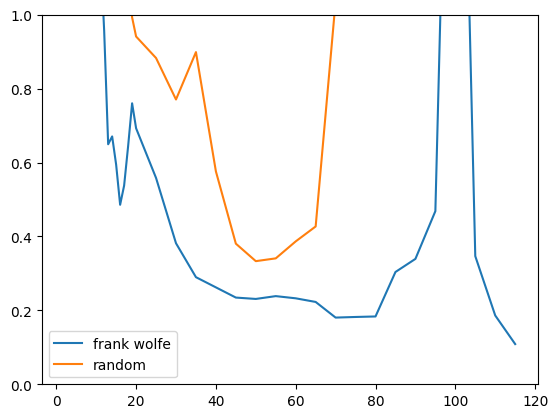

In [14]:
# plt.plot(rang, np.array(err_cvx).mean(0).squeeze(), label='convex')
plt.plot(rang, np.array(err_fw).mean(0).squeeze(), label='frank wolfe')
plt.plot(rang, np.array(err_rand).mean(0).squeeze(), label='random')
plt.ylim(0, 1)
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
w = np.ones(len(x_s)) / len(x_s)
w[0] += 0.4

w = np.ones(len(x_s)) / len(x_s)
np.allclose(
    x_s.T @ np.diag(w) @ x_s + 0.4 * np.outer(x_s[0], x_s[0]),
    x_s.T @ np.diag(w) @ x_s
)

In [173]:
# Assuming x_s is your data matrix
w = np.ones(len(x_s)) / len(x_s)
delta = 0.1

# Increase the first weight
w[0] += delta

# Direct computation of the weighted covariance matrix
cov_direct = x_s.T @ np.diag(w) @ x_s

# Compute the rank-one update equivalent
u = x_s[0]
v = x_s[0]
rank_one_update = delta * np.outer(u, v)

# Apply the rank-one update to the covariance matrix with original weights
cov_rank_one_updated = (x_s.T @ np.diag(np.ones(len(x_s)) / len(x_s)) @ x_s) + rank_one_update

# Check if they are close
np.allclose(cov_direct, cov_rank_one_updated)

True

In [206]:
w = np.ones(len(x_s)) / len(x_s)
np.cov(x_s, rowvar=False, aweights=w, bias=True)

array([[ 1.04036182e-02, -2.31136821e-05,  6.16743075e-04, ...,
        -1.72492012e-04,  2.08171682e-04, -6.55832088e-04],
       [-2.31136821e-05,  1.19037072e-02, -8.70871939e-05, ...,
         2.49297972e-04,  1.85351216e-04,  4.56091134e-04],
       [ 6.16743075e-04, -8.70871939e-05,  1.06349471e-02, ...,
         2.60049130e-04,  8.86319428e-05, -3.01347297e-04],
       ...,
       [-1.72492012e-04,  2.49297972e-04,  2.60049130e-04, ...,
         1.02737976e-02,  3.40973180e-04, -2.01811011e-05],
       [ 2.08171682e-04,  1.85351216e-04,  8.86319428e-05, ...,
         3.40973180e-04,  1.10321168e-02,  3.36743219e-04],
       [-6.55832088e-04,  4.56091134e-04, -3.01347297e-04, ...,
        -2.01811011e-05,  3.36743219e-04,  1.18662794e-02]])

In [207]:
x_s.T @ np.diag(w) @ x_s

array([[ 1.04268356e-02, -1.42135350e-05,  6.05364944e-04, ...,
        -1.63964747e-04,  2.03057149e-04, -6.65603116e-04],
       [-1.42135350e-05,  1.19071190e-02, -9.14488710e-05, ...,
         2.52566802e-04,  1.83390618e-04,  4.52345521e-04],
       [ 6.05364944e-04, -9.14488710e-05,  1.06405232e-02, ...,
         2.55870191e-04,  9.11384116e-05, -2.96558829e-04],
       ...,
       [-1.63964747e-04,  2.52566802e-04,  2.55870191e-04, ...,
         1.02769295e-02,  3.39094724e-04, -2.37697865e-05],
       [ 2.03057149e-04,  1.83390618e-04,  9.11384116e-05, ...,
         3.39094724e-04,  1.10332435e-02,  3.38895662e-04],
       [-6.65603116e-04,  4.52345521e-04, -2.96558829e-04, ...,
        -2.37697865e-05,  3.38895662e-04,  1.18703915e-02]])

In [212]:
import frank_wolfe
T = 100
k = 5
alpha = 0.1
w = np.ones(len(x_s)) / len(x_s)
# inv_cov_real = np.linalg.inv( np.cov(x_s, rowvar=False, aweights=w, bias=True))
inv_cov_real = np.linalg.inv(x_s.T.dot(np.diag(w).dot(x_s)))
inv_cov_sher = inv_cov_real.copy()
for i in range(T):
    loss = frank_wolfe.compute_exp_design_loss(x_b, inv_cov_real)
    neg_grad = frank_wolfe.compute_neg_gradient(x_s, x_b, inv_cov_real)
    update_coord = np.argmax(neg_grad)

    w *= 1 - alpha
    w[update_coord] += alpha

    # inv_cov_real = np.linalg.inv( np.cov(x_s, rowvar=False, aweights=w))
    inv_cov_real = np.linalg.inv(x_s.T @ np.diag(w) @ x_s)
    
    inv_cov_sher /= 1 - alpha
    
    inv_cov_sher = frank_wolfe.sherman_morrison_update_inverse(
        inv_cov_sher, 
        alpha * x_s[update_coord, :],
        x_s[update_coord, :],
    )
    if i < 20 or i % 10 == 0:
        # print(np.linalg.cond(x_s.T @ np.diag(w) @ x_s))
        print('diff', 
              np.mean(np.square(inv_cov_real - inv_cov_sher)), 
              (np.square(inv_cov_real - inv_cov_sher)).max(),
              inv_cov_real.max()
             )

        print('weight_error', get_error(x_b, y_b, x_s, y_s, w, k=k), f'{update_coord=}')
        print('grad_error', get_error(x_b, y_b, x_s, y_s, neg_grad, k=k), f'{update_coord=}')
        print('rand_error', get_error(x_b, y_b, x_s, y_s, np.random.permutation(len(x_s)), k=k), f'{update_coord=}')

diff 1.700393621319141e-28 2.0194839173657902e-26 121.89345085528863
weight_error [2.08591687] update_coord=501
grad_error [1.76719889] update_coord=501
rand_error [1.37934505] update_coord=501
diff 3.4719650897923e-28 3.4129278203481855e-26 135.01951090674422
weight_error [2.99300942] update_coord=477
grad_error [1.59109899] update_coord=477
rand_error [1.35619191] update_coord=477
diff 7.680546337571575e-28 3.958188478036949e-26 148.78532974565064
weight_error [1.27429643] update_coord=70
grad_error [0.04518043] update_coord=70
rand_error [1.08814667] update_coord=70
diff 1.1014174452649994e-27 1.3651711281392742e-25 163.6768452487931
weight_error [0.94318012] update_coord=927
grad_error [2.72161163] update_coord=927
rand_error [1.13864658] update_coord=927
diff 1.715953221127285e-27 9.774302160050425e-26 180.27918830253466
weight_error [0.58008968] update_coord=258
grad_error [1.00928721] update_coord=258
rand_error [1.56536877] update_coord=258
diff 2.8132176668081853e-27 2.6172511

[0.95173164]
[0.23249467]


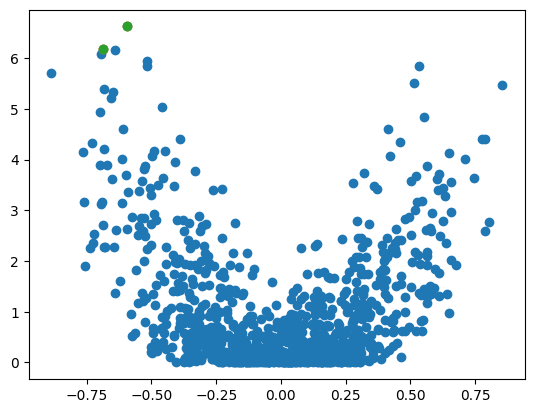

In [160]:
k = 2

print(get_error(x_b, y_b, x_s, y_s, neg_grad, k=k))
print(get_error(x_b, y_b, x_s, y_s, np.arange(len(x_s)), k=k))


from sklearn.metrics.pairwise import cosine_similarity
plt.scatter(cosine_similarity(x_b, x_s), neg_grad)
sel = neg_grad.argsort()[::-1][:k]
plt.scatter(cosine_similarity(x_b, x_s)[:, sel], neg_grad[sel])
plt.scatter(cosine_similarity(x_b, x_s)[:, sel], neg_grad[sel])

In [195]:
np.cov(x_s, rowvar=False) - (x_s.T @ x_s)

array([[-10.40599477,   0.01417618,  -0.60414222, ...,   0.16362812,
         -0.20264571,   0.66428102],
       [  0.01417618, -11.88329624,   0.09127025, ...,  -0.25206469,
         -0.18302169,  -0.45143663],
       [ -0.60414222,   0.09127025, -10.61923703, ...,  -0.25535401,
         -0.09095855,   0.29596062],
       ...,
       [  0.16362812,  -0.25206469,  -0.25535401, ..., -10.25636844,
         -0.33841431,   0.02372582],
       [ -0.20264571,  -0.18302169,  -0.09095855, ...,  -0.33841431,
        -11.01116708,  -0.33821969],
       [  0.66428102,  -0.45143663,   0.29596062, ...,   0.02372582,
         -0.33821969, -11.84664293]])

In [265]:
reload(main_gaussian)
data = utils.get_gaussian_data(num=1000, dim=100, noise=0.5)
x = data['X']
y = data['y']
coef = data['coef']
x_b = x[0, None]
y_b = x_b @ coef
x_s = x[1:]
y_s = y[1:]

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 329.08it/s]


Text(0.5, 1.0, 'weights')

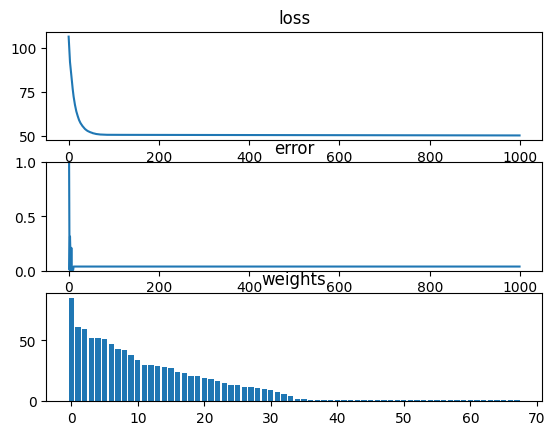

In [266]:
reload(main_gaussian)
reload(frank_wolfe)
r = main_gaussian.design_selection( 
    (x_s, y_s), (x_b, y_b),
    num_iters=1000,
    alpha=0.1,
    num_select=10,
    recompute_interval=0,
    line_search=True,
)
fig, ax = plt.subplots(3)
ax[0].plot(*zip(*r['losses'].items()))
ax[0].set_title('loss')
ax[1].plot(*zip(*r['errors'].items()))
ax[1].set_title('error')
# ax[1].set_yscale('log')
ax[1].set_ylim(0, 1)

weights = np.bincount(np.array(list(r['coords'].values())).squeeze())
weights = sorted(weights[weights > 0], reverse=True)
ax[2].bar(np.arange(len(weights)), weights)
ax[2].set_title('weights')

In [12]:
# from scipy import stats
# k = 30
# a, b = w_cvx.argsort()[-k:], w_fw.argsort()[-k:]
# plt.scatter(a, b)
# rho, pval = stats.spearmanr(a, b)
# plt.title(fr'{rho = :.4f}     {pval = :.4f}')

In [71]:
figure_dir = Path('figures')
figure_dir.mkdir(exist_ok=True)

In [72]:
import cvxpy as cp

def optimize_seller_weights(seller_data, buyer_data):
    
    num_seller_data = seller_data.shape[0]
    seller_weights = cp.Variable((num_seller_data, 1))
    
    def objective(seller_weights, seller_data, buyer_data):
        cost = cp.matrix_frac(
                buyer_data.T,
                cp.sum([
                    seller_weights[i] * seller_data[i][None].T @ seller_data[i][None] 
                     for i in range(seller_data.shape[0])
                ])
            ) / buyer_data.shape[0]
        # reg1 = cp.norm1(seller_weights)
        # reg2 = cp.pnorm(seller_weights)
        # loss = cost + lam1 * reg1 + lam2 * reg2
        loss = cost 
        return loss
    
    # constraints = [seller_weights >= 0]
    constraints = [seller_weights >= 0, sum(seller_weights) == 1]
    prob = cp.Problem(cp.Minimize(objective(seller_weights, seller_data, buyer_data)), constraints)
    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(prob.status, f"{runtime=:.1f}\t{prob.value=:.2f}")
    return seller_weights.value.flatten()

In [73]:
def fit_predict(train_data, train_targets, test_data, test_targets):
    LR = LinearRegression()
    LR.fit(train_data, train_targets)
    test_pred = LR.predict(test_data)
    return mean_squared_error(test_targets, test_pred)

In [75]:
num_sellers = 6

# dataset = 'synthetic'
dataset = 'diabetes'
# dataset = 'housing'
# dataset = 'fire'
# dataset = 'wine'
num_trials = 1
num_buy = [1, 3, 5, 10, 30]
# num_buy = [1, 3, 5]

if dataset == 'synthetic':
    n = 1000
    b1 = -0
    b2 = 20
    x1 = 10 * np.random.randn(n) - 15
    x2 = 5 * np.random.randn(n) - 5
    x3 = 15 * np.random.randn(n) - 20
    x4 = 3 * np.random.randn(n) + 10
    e = 0.1 * np.random.randn(n)
    y1 = b1 + x1 + x2 + e
    y2 = b2 + x3 + x4 + e

    x = np.concatenate([
        np.stack([x1, x2], 1), 
        np.stack([x3, x4], 1), 
    ])
    
    y = np.concatenate([y1, y2])

    # plt.scatter(x1, y1, marker='.')
    # plt.scatter(x2, y2, marker='.')
    num_sellers = 2
    num_trials = 3
elif dataset == 'diabetes':
    data = load_diabetes()
    x = data["data"]
    y = data["target"]
elif dataset == 'housing':
    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    housing_df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
    exclude = ['CHAS']
    housing_df = housing_df.drop(columns=exclude)
    x = housing_df.iloc[:, :12].values
    y = housing_df.MEDV.values
elif dataset == 'fires':
    fire_df = pd.read_csv('../data/forestfires.csv')
    fire_df.month = pd.get_dummies(fire_df.month).values.argmax(1)
    fire_df.day = pd.get_dummies(fire_df.day).values.argmax(1)
    fire_df.drop(columns=['month', 'day'], inplace=True)
    x = fire_df.iloc[:, :10]
    y = fire_df.area
elif dataset == 'wine':
    wine_df = pd.read_csv('../data/winequality-red.csv', sep=';')
    x = wine_df.iloc[:, :11]
    y = wine_df.quality.values

MMS = MinMaxScaler()
scaled_x = MMS.fit_transform(x)
scaled_y = MMS.fit_transform(y[:, None]).flatten()
    
KM = KMeans(n_clusters=num_sellers, init='k-means++').fit(scaled_x)
clusters_x = {i: scaled_x[KM.labels_ == i] for i in range(num_sellers)}
clusters_y = {i: scaled_y[KM.labels_ == i] for i in range(num_sellers)}

trial_buyer_errors = {i: defaultdict(list) for i in range(num_sellers)}
trial_buyer_baselines = {i: defaultdict(list) for i in range(num_sellers)}

trial_seller_weight_clusters = {}
trial_num_seller = defaultdict(list)
trial_num_buyer = defaultdict(list)
trial_num_test = defaultdict(list)

import design
from importlib import reload
reload(design)
V =design.Valuator()

for trial in tqdm(range(num_trials)):
    train_x, test_x, train_y, test_y = train_test_split(scaled_x, scaled_y, test_size=0.32, random_state=trial)
    sell_x, buy_x, sell_y, buy_y = train_test_split(train_x, train_y, test_size=0.32, random_state=trial)
    KM = KMeans(n_clusters=num_sellers, init='k-means++').fit(test_x)
    sell_clusters = KM.predict(sell_x)
    buy_clusters = KM.predict(buy_x)
    print('test', np.bincount(KM.labels_))
    print('buyer', np.bincount(buy_clusters))
    print('seller', np.bincount(sell_clusters))
    for j in range(num_sellers):
        trial_num_test[j].append(np.bincount(KM.labels_)[j])
        trial_num_buyer[j].append(np.bincount(buy_clusters)[j])
        trial_num_seller[j].append(np.bincount(sell_clusters)[j])
    
    test_x_partition = {k: test_x[KM.labels_ == k] for k in range(num_sellers)}
    test_y_partition = {k: test_y[KM.labels_ == k] for k in range(num_sellers)}
    
    buyer_x_partition = {k: buy_x[buy_clusters == k] for k in range(num_sellers)}
    buyer_y_partition = {k: buy_y[buy_clusters == k] for k in range(num_sellers)}
    
    buyer_weights = {i: {} for i in range(num_sellers)}

    # for k in tqdm(np.arange(1, 30, 5)):
    for k in tqdm(num_buy):
        print('\t', str(k).center(20, '-'))
        # if k == 0:
            # k = 1
        for j in range(num_sellers):
            print(f'    buyer {j}', end='\t')
            # buyer_weights[j][k] = optimize_seller_weights(sell_x, buyer_x_partition[j][:k])
            buyer_weights[j][k] = V.optimize(buyer_x_partition[j][:k], sell_x)
            
        
    train_range = np.arange(2, 100)
    
    
    np.random.seed(trial)
    random_index = np.random.permutation(np.arange(sell_x.shape[0]))
    
    seller_cluster_weights = {j: {} for j in range(num_sellers)}
    
    for j in range(num_sellers):
        trial_buyer_baselines[j]['seller'].append([
            fit_predict(sell_x[random_index][:num_train], sell_y[random_index][:num_train], test_x_partition[j], test_y_partition[j]) for num_train in train_range
        ])
        trial_buyer_baselines[j]['buyer'].append([
            fit_predict(buyer_x_partition[j][:num_train], buyer_y_partition[j][:num_train], test_x_partition[j], test_y_partition[j]) for num_train in train_range
        ])
                                   
        for n_buy, w in buyer_weights[j].items():
            sorted_weight_index = w.argsort()
            trial_buyer_errors[j][n_buy].append([
                fit_predict(
                    sell_x[sorted_weight_index[:-num_train:-1]], 
                    sell_y[sorted_weight_index[:-num_train:-1]], 
                    test_x_partition[j], test_y_partition[j],
                ) for num_train in train_range
            ])

            seller_cluster_weights[j][n_buy] = sell_clusters[sorted_weight_index[::-1]]
            
    trial_seller_weight_clusters[trial] = seller_cluster_weights
    
    print(f' {trial=} done '.center(40, '#'))

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/1 [00:00<?, ?it/s]

test [27 17 31 22 23 22]
buyer [15 16 16 14 19 16]
seller [33 38 35 30 28 40]


/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 0	optimal runtime=0.5	prob.value=1.75
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=8.2	prob.value=1.06
    buyer 2	optimal_inaccurate runtime=8.2	prob.value=13.53
    buyer 3	optimal runtime=2.0	prob.value=2.73
    buyer 4	optimal_inaccurate runtime=8.2	prob.value=164.25
    buyer 5	optimal runtime=3.1	prob.value=2.17
	 ---------3----------
    buyer 0	optimal_inaccurate runtime=9.1	prob.value=3.47
    buyer 1	optimal_inaccurate runtime=9.0	prob.value=3.08
    buyer 2	optimal_inaccurate runtime=8.9	prob.value=5.82
    buyer 3	optimal_inaccurate runtime=8.9	prob.value=9.35
    buyer 4	optimal_inaccurate runtime=8.9	prob.value=35.06
    buyer 5	optimal_inaccurate runtime=8.9	prob.value=3.98
	 ---------5----------
    buyer 0	optimal_inaccurate runtime=10.0	prob.value=3.99
    buyer 1	optimal_inaccurate runtime=10.1	prob.value=3.16
    buyer 2	optimal_inaccurate runtime=9.9	prob.value=5.45
    buyer 3	optimal_inaccurate runtime=10.0	prob.value=6.73
    buyer 4	optimal_inaccurate runtime=9.8	prob.value=12.45
    buyer 5	optimal_inaccurate runti

SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
cmap = matplotlib.colormaps['viridis'].colors

colors = np.array(cmap)[np.linspace(0, 255, len(trial_buyer_errors[0])).astype(int)]
elinewidth=0.0
errorevery=5
capsize=0
lw = 3

fig, ax = plt.subplots(ncols=num_sellers, figsize=(6 * num_sellers, 10))

for j in range(num_sellers):
    
    for i, (k, v) in enumerate(trial_buyer_errors[j].items()):
        # lw = 3 if i == (len(num_buy) - 1) else 1
        ax[j].errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=lw, label=f'{k} buyer data' if j == 0 else None, c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
    ax[j].plot(np.array(trial_buyer_baselines[j]['seller']).mean(0), c='k', lw=4, ls='--', label='random baseline' if j == 0 else None)
    ax[j].plot(np.array(trial_buyer_baselines[j]['buyer']).mean(0), c='gray', lw=4, ls=':', label='buyer baseline' if j == 0 else None)
    ax[j].set_xlabel('Subset size', fontsize=18, labelpad=10)
    ax[j].axvline(np.mean(trial_num_seller[j]), c='k', lw=2, label='seller total' if j == 0 else None)
    ax[j].axvline(np.mean(trial_num_buyer[j]), c='gray', lw=2, label='buyer total' if j == 0 else None)
    if j == 0:
        ax[j].set_ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
    ax[j].tick_params(labelsize=18)
    ax[j].set_yscale('log')
    ax[j].set_ylim(0.01, 100)
    ax[j].set_title(f'buyer {j}', fontsize=22)
    
fig.suptitle(dataset, fontsize=28)
fig.legend(fontsize=20, title_fontsize=18, bbox_to_anchor=(0.8, 0.00), ncol=3)
# plt.savefig(figure_dir / f'subset-{dataset}.png', bbox_inches='tight')
    
plt.show()

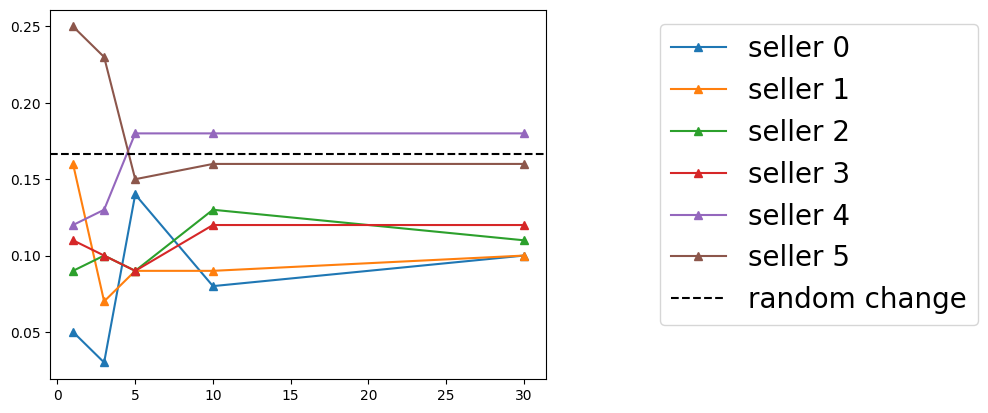

In [11]:
k = 100
# k = 30
for j in range(num_sellers):
    plt.plot(num_buy, [np.bincount(trial_seller_weight_clusters[0][j][n_buy][:k])[j] / k for n_buy in num_buy], marker='^', label=f'seller {j}')
plt.axhline((x.shape[0] / num_sellers) / x.shape[0], label='random change', ls='--', c='k')
plt.legend(fontsize=20, title_fontsize=18, bbox_to_anchor=(1.2, 1.00))
# plt.savefig(figure_dir / f'selected-{dataset}.png', bbox_inches='tight')
plt.show()

## Feature subset setting

## TODO

* repeat feature experiments with synthetic $y$
    1. fit regression on all data to estimate $\vec{\beta}$
    2. parition sellers by features
    3. apply $\hat{\beta}$ to subset of features for each seller and add optionally add bias / gaussian noise $\epsilon$
* plot histogram of optimized weights / plot efficincecy of selected data points 

In [13]:
(trial_buyer3_weights[0][10].argsort() < 480)

NameError: name 'trial_buyer3_weights' is not defined

In [786]:
(trial_buyer2_weights[0][10].argsort() < 240)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True, False, False, False, False, False,  True,
       False, False,

In [788]:
trial_buyer1_weights[0][25].argsort() < 120

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [762]:
# num_sellers = 5

# dataset = 'diabetes'
# dataset = 'housing'
dataset = 'wine'
num_trials = 10

if dataset == 'diabetes':
    data = load_diabetes()
    x = data["data"]
    y = data["target"]
elif dataset == 'housing':
    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    housing_df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
    exclude = ['CHAS']
    housing_df = housing_df.drop(columns=exclude)
    x = housing_df.iloc[:, :12].values
    y = housing_df.MEDV.values
elif dataset == 'wine':
    wine_df = pd.read_csv('../data/winequality-red.csv', sep=';')
    x = wine_df.iloc[:, :11]
    y = wine_df.quality.values


MMS = MinMaxScaler()
scaled_x = MMS.fit_transform(x)
scaled_y = MMS.fit_transform(y[:, None]).flatten()

global_LR = LinearRegression()
global_LR.fit(scaled_x, scaled_y)

beta = global_LR.coef_
bias = global_LR.intercept_

trial_buyer1_errors = defaultdict(list)
trial_buyer2_errors = defaultdict(list)
trial_buyer3_errors = defaultdict(list)
trial_buyer4_errors = defaultdict(list)

trial_buyer1_baselines = defaultdict(list)
trial_buyer2_baselines = defaultdict(list)
trial_buyer3_baselines = defaultdict(list)
trial_buyer4_baselines = defaultdict(list)

trial_buyer1_weights = {}
trial_buyer2_weights = {}
trial_buyer3_weights = {}
trial_buyer4_weights = {}

trial_seller_data = defaultdict(dict)

for trial in range(num_trials):
    train_x, test_x, train_y, test_y = train_test_split(scaled_x, np.ones_like(scaled_x), test_size=0.32, random_state=trial)
    sell_x, buy_x, sell_y, buy_y = train_test_split(train_x, train_y, test_size=0.333, random_state=trial)
   
    if dataset == 'diabetes':
        x_sell = np.concatenate([
            np.pad(sell_x[:40,      :2],  ((0, 0), (0, 8))),
            np.pad(sell_x[40:80,   2:4],  ((0, 0), (2, 6))),
            np.pad(sell_x[80:120,  4:6],  ((0, 0), (4, 4))),
            np.pad(sell_x[120:160, 6:8],  ((0, 0), (6, 2))),
            np.pad(sell_x[160:,   8:10], ((0, 0), (8, 0))),
        ])
        y_sell = bias + beta @ x_sell.T

        x_buyer1 = np.pad(buy_x[:, :2], ((0, 0), (0, 8)))
        x_buyer2 = np.pad(buy_x[:, :3], ((0, 0), (0, 7)))
        x_buyer3 = np.pad(buy_x[:, :5], ((0, 0), (0, 5)))
        x_buyer4 = buy_x
        
        y_buyer1 = bias + beta @ x_buyer1.T
        y_buyer2 = bias + beta @ x_buyer2.T
        y_buyer3 = bias + beta @ x_buyer3.T
        y_buyer4 = bias + beta @ x_buyer4.T

        x_test1  = np.pad(test_x[:, :2], ((0, 0), (0, 8))) 
        x_test2  = np.pad(test_x[:, :3], ((0, 0), (0, 7))) 
        x_test3  = np.pad(test_x[:, :5], ((0, 0), (0, 5))) 
        x_test4  = test_x
        
        y_test1 = bias + beta @ x_test1.T
        y_test2 = bias + beta @ x_test2.T
        y_test3 = bias + beta @ x_test3.T
        y_test4 = bias + beta @ x_test4.T
        
    elif dataset == 'housing':
        x_sell = np.concatenate([
            np.pad(sell_x[:50,      :3],   ((0, 0), (0, 9))),
            np.pad(sell_x[50:100,  2:5],   ((0, 0), (2, 7))),
            np.pad(sell_x[100:150, 4:9],  ((0, 0), (4, 3))),
            np.pad(sell_x[150:200, 8:12],  ((0, 0), (8, 0))),
        ])
        y_sell = bias + beta @ x_sell.T

        x_buyer1  = np.pad(buy_x[:, :2], ((0, 0), (0, 10))) 
        x_buyer2  = np.pad(buy_x[:, :4], ((0, 0), (0, 8))) 
        x_buyer3  = np.pad(buy_x[:, :8], ((0, 0), (0, 4))) 
        x_buyer4  = np.pad(buy_x[:, :10], ((0, 0), (0, 2))) 
        assert x_buyer1.shape == x_buyer2.shape == x_buyer3.shape == x_buyer4.shape
        
        y_buyer1 = bias + beta @ x_buyer1.T
        y_buyer2 = bias + beta @ x_buyer2.T
        y_buyer3 = bias + beta @ x_buyer3.T
        y_buyer4 = bias + beta @ x_buyer4.T

        x_test1  = np.pad(test_x[:, :2], ((0, 0), (0, 10))) 
        x_test2  = np.pad(test_x[:, :4], ((0, 0), (0, 8))) 
        x_test3  = np.pad(test_x[:, :8], ((0, 0), (0, 4))) 
        x_test4  = np.pad(test_x[:, :10], ((0, 0), (0, 2))) 
        assert x_test1.shape == x_test2.shape == x_test3.shape == x_test4.shape
        
        y_test1 = bias + beta @ x_test1.T
        y_test2 = bias + beta @ x_test2.T
        y_test3 = bias + beta @ x_test3.T
        y_test4 = bias + beta @ x_test4.T
        
    elif dataset == 'wine':
        x_sell = np.concatenate([
            np.pad(sell_x[:120,      :2],   ((0, 0), (0, 9))),
            np.pad(sell_x[120:240, 2:4],   ((0, 0), (2, 7))),
            np.pad(sell_x[240:360, 4:6],  ((0, 0), (4, 5))),
            np.pad(sell_x[360:480, 6:8],  ((0, 0), (6, 3))),
            np.pad(sell_x[480:600, 8:10],  ((0, 0), (8, 1))),
            np.pad(sell_x[600:720, 10:11],  ((0, 0), (10, 0))),
        ])
        y_sell = bias + beta @ x_sell.T

        x_buyer1  = np.pad(buy_x[:, :2], ((0, 0), (0, 9))) 
        x_buyer2  = np.pad(buy_x[:, :4], ((0, 0), (0, 7))) 
        x_buyer3  = np.pad(buy_x[:, :8], ((0, 0), (0, 3))) 
        x_buyer4  = np.pad(buy_x[:, :11], ((0, 0), (0, 0))) 
        assert x_buyer1.shape == x_buyer2.shape == x_buyer3.shape == x_buyer4.shape
        
        y_buyer1 = bias + beta @ x_buyer1.T
        y_buyer2 = bias + beta @ x_buyer2.T
        y_buyer3 = bias + beta @ x_buyer3.T
        y_buyer4 = bias + beta @ x_buyer4.T

        x_test1  = np.pad(test_x[:, :2], ((0, 0), (0, 9))) 
        x_test2  = np.pad(test_x[:, :4], ((0, 0), (0, 7))) 
        x_test3  = np.pad(test_x[:, :8], ((0, 0), (0, 3))) 
        x_test4  = np.pad(test_x[:, :11], ((0, 0), (0, 0))) 
        assert x_test1.shape == x_test2.shape == x_test3.shape == x_test4.shape
        
        y_test1 = bias + beta @ x_test1.T
        y_test2 = bias + beta @ x_test2.T
        y_test3 = bias + beta @ x_test3.T
        y_test4 = bias + beta @ x_test4.T

    trial_seller_data[trial]['x'] = x_sell
    trial_seller_data[trial]['y'] = y_sell
    
    buyer1_weights = {}
    buyer2_weights = {}
    buyer3_weights = {}
    buyer4_weights = {}

    # for k in tqdm(np.arange(1, 20, 1)):
    # for k in tqdm(np.arange(1, 30, 5)):
    for k in tqdm([1, 5, 10, 25, 50]):
        print('\t', str(k).center(20, '-'))
        # if k == 0:
            # k = 1
        print('    buyer 1', end='\t')
        buyer1_weights[k] = optimize_seller_weights(x_sell, x_buyer1[:k])
        print('    buyer 2', end='\t')
        buyer2_weights[k] = optimize_seller_weights(x_sell, x_buyer2[:k])
        print('    buyer 3', end='\t')
        buyer3_weights[k] = optimize_seller_weights(x_sell, x_buyer3[:k])
        print('    buyer 4', end='\t')
        buyer4_weights[k] = optimize_seller_weights(x_sell, x_buyer4[:k])
        
    trial_buyer1_weights[trial] = buyer1_weights
    trial_buyer2_weights[trial] = buyer2_weights
    trial_buyer3_weights[trial] = buyer3_weights
    trial_buyer4_weights[trial] = buyer4_weights
    
    train_range = np.arange(2, x_sell.shape[0])
        
    np.random.seed(trial)
    random_index = np.random.permutation(np.arange(x_sell.shape[0]))
                                   
    trial_buyer1_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test1, y_test1) for num_train in train_range
    ])
    trial_buyer2_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test2, y_test2) for num_train in train_range
    ])
    trial_buyer3_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test3, y_test3) for num_train in train_range
    ])
    trial_buyer4_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test4, y_test4) for num_train in train_range
    ])
    
    trial_buyer1_baselines['buyer'].append([
        fit_predict(x_buyer1[:num_train], y_buyer1[:num_train], x_test1, y_test1) for num_train in train_range
    ])
    trial_buyer2_baselines['buyer'].append([
        fit_predict(x_buyer2[:num_train], y_buyer2[:num_train], x_test2, y_test2) for num_train in train_range
    ])
    trial_buyer3_baselines['buyer'].append([
        fit_predict(x_buyer3[:num_train], y_buyer3[:num_train], x_test3, y_test3) for num_train in train_range
    ])
    trial_buyer4_baselines['buyer'].append([
        fit_predict(x_buyer4[:num_train], y_buyer4[:num_train], x_test4, y_test4) for num_train in train_range
    ])
                                   
    for num_buy, w in buyer1_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer1_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test1, y_test1,
            ) for num_train in train_range
        ])

    for num_buy, w in buyer2_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer2_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test2, y_test2,
            ) for num_train in train_range
        ])

    for num_buy, w in buyer3_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer3_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test3, y_test3,
            ) for num_train in train_range
        ])

    for num_buy, w in buyer4_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer4_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test4, y_test4,
            ) for num_train in train_range
        ])

    print(f' {trial=} done '.center(40, '#'))

  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.6	prob.value=0.18
    buyer 2	optimal runtime=1.5	prob.value=0.59
    buyer 3	optimal runtime=1.6	prob.value=2.57
    buyer 4	optimal runtime=3.0	prob.value=6.98
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.24
    buyer 2	optimal runtime=1.6	prob.value=0.75
    buyer 3	optimal runtime=5.0	prob.value=4.41
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=9.5	prob.value=11.56
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.37
    buyer 2	optimal runtime=2.0	prob.value=1.29
    buyer 3	optimal_inaccurate runtime=12.3	prob.value=6.14
    buyer 4	optimal_inaccurate runtime=12.8	prob.value=13.49
	 ---------25---------
    buyer 1	optimal runtime=1.6	prob.value=0.55
    buyer 2	optimal runtime=2.3	prob.value=3.03
    buyer 3	optimal_inaccurate runtime=24.1	prob.value=12.01
    buyer 4	optimal_inaccurate runtime=23.7	prob.value=29.91
	 ---------50---------
    buyer 1	optimal runtime=1.8	prob.value=0.54
    buyer 2	optimal runtime=6.7	prob.value=2.96
    buyer 3	optimal_inaccurate runtime=52.8	prob.value=11.99
    buyer 4	optimal_inaccurate runtime=54.1	prob.value=30.31
############# trial=0 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.6	prob.value=0.04
    buyer 2	optimal runtime=1.6	prob.value=4.18
    buyer 3	optimal runtime=1.7	prob.value=10.74
    buyer 4	optimal runtime=5.0	prob.value=19.20
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.21
    buyer 2	optimal runtime=2.6	prob.value=2.09
    buyer 3	optimal runtime=4.9	prob.value=9.80
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=9.5	prob.value=19.32
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.26
    buyer 2	optimal runtime=1.6	prob.value=1.66
    buyer 3	optimal runtime=7.0	prob.value=7.90
    buyer 4	optimal_inaccurate runtime=12.7	prob.value=20.77
	 ---------25---------
    buyer 1	optimal runtime=1.7	prob.value=0.44
    buyer 2	optimal runtime=1.9	prob.value=1.74
    buyer 3	optimal_inaccurate runtime=23.4	prob.value=6.97
    buyer 4	optimal_inaccurate runtime=23.7	prob.value=19.06
	 ---------50---------
    buyer 1	optimal runtime=2.9	prob.value=0.50
    buyer 2	optimal runtime=2.8	prob.value=1.65
    buyer 3	optimal_inaccurate runtime=54.2	prob.value=6.65
    buyer 4	optimal_inaccurate runtime=56.5	prob.value=18.51
############# trial=1 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.7	prob.value=0.25
    buyer 2	optimal runtime=1.7	prob.value=0.67
    buyer 3	optimal runtime=3.4	prob.value=4.73
    buyer 4	optimal runtime=7.7	prob.value=10.34
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.54
    buyer 2	optimal runtime=1.6	prob.value=1.59
    buyer 3	optimal runtime=5.3	prob.value=8.10
    buyer 4	optimal runtime=8.0	prob.value=14.47
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.84
    buyer 2	optimal runtime=1.7	prob.value=2.39
    buyer 3	optimal runtime=11.6	prob.value=11.09
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=12.7	prob.value=20.69
	 ---------25---------
    buyer 1	optimal runtime=2.0	prob.value=0.75
    buyer 2	optimal runtime=5.0	prob.value=2.04
    buyer 3	optimal_inaccurate runtime=23.3	prob.value=9.84
    buyer 4	optimal_inaccurate runtime=23.4	prob.value=18.36
	 ---------50---------
    buyer 1	optimal runtime=1.9	prob.value=0.71
    buyer 2	optimal runtime=12.1	prob.value=2.60
    buyer 3	optimal_inaccurate runtime=53.9	prob.value=11.34
    buyer 4	optimal_inaccurate runtime=52.6	prob.value=27.64
############# trial=2 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.6	prob.value=0.14
    buyer 2	optimal runtime=1.6	prob.value=0.73
    buyer 3	optimal runtime=2.1	prob.value=2.85
    buyer 4	optimal runtime=2.0	prob.value=8.20
	 ---------5----------
    buyer 1	optimal runtime=3.2	prob.value=0.38
    buyer 2	optimal runtime=1.6	prob.value=1.65
    buyer 3	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=9.7	prob.value=6.66
    buyer 4	optimal_inaccurate runtime=11.0	prob.value=13.36
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.46
    buyer 2	optimal runtime=2.0	prob.value=1.71
    buyer 3	optimal_inaccurate runtime=14.2	prob.value=6.68
    buyer 4	optimal_inaccurate runtime=12.8	prob.value=24.50
	 ---------25---------
    buyer 1	optimal runtime=1.6	prob.value=0.52
    buyer 2	optimal runtime=2.2	prob.value=1.84
    buyer 3	optimal_inaccurate runtime=23.0	prob.value=20.00
    buyer 4	optimal_inaccurate runtime=25.6	prob.value=53.87
	 ---------50---------
    buyer 1	optimal runtime=1.8	prob.value=0.54
    buyer 2	optimal runtime=3.8	prob.value=1.77
    buyer 3	optimal_inaccurate runtime=52.9	prob.value=44.38
    buyer 4	optimal_inaccurate runtime=52.5	prob.value=51.99
############# trial=3 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.5	prob.value=0.40
    buyer 2	optimal runtime=2.9	prob.value=1.80
    buyer 3	optimal runtime=2.5	prob.value=4.06
    buyer 4	optimal runtime=5.0	prob.value=8.40
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.58
    buyer 2	optimal runtime=1.6	prob.value=2.77
    buyer 3	optimal runtime=9.0	prob.value=8.28
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=9.9	prob.value=18.20
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.55
    buyer 2	optimal runtime=4.1	prob.value=5.05
    buyer 3	optimal_inaccurate runtime=13.0	prob.value=13.36
    buyer 4	optimal_inaccurate runtime=12.5	prob.value=24.35
	 ---------25---------
    buyer 1	optimal runtime=2.8	prob.value=0.60
    buyer 2	optimal runtime=4.9	prob.value=3.56
    buyer 3	optimal_inaccurate runtime=23.2	prob.value=10.10
    buyer 4	optimal_inaccurate runtime=23.8	prob.value=78.70
	 ---------50---------
    buyer 1	optimal runtime=1.9	prob.value=0.74
    buyer 2	optimal runtime=29.6	prob.value=3.68
    buyer 3	optimal_inaccurate runtime=52.5	prob.value=24.09
    buyer 4	optimal_inaccurate runtime=51.7	prob.value=66.65
############# trial=4 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.6	prob.value=0.44
    buyer 2	optimal runtime=1.6	prob.value=2.12
    buyer 3	optimal runtime=2.0	prob.value=5.03
    buyer 4	optimal runtime=3.9	prob.value=10.95
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.51
    buyer 2	optimal runtime=1.9	prob.value=1.45
    buyer 3	optimal runtime=4.0	prob.value=5.00
    buyer 4	optimal runtime=5.4	prob.value=10.44
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.64
    buyer 2	optimal runtime=3.2	prob.value=1.69
    buyer 3	optimal runtime=7.0	prob.value=5.06
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=13.3	prob.value=11.57
	 ---------25---------
    buyer 1	optimal runtime=1.6	prob.value=0.59
    buyer 2	optimal runtime=2.0	prob.value=1.77
    buyer 3	optimal runtime=16.2	prob.value=5.94
    buyer 4	optimal_inaccurate runtime=23.9	prob.value=12.78
	 ---------50---------
    buyer 1	optimal runtime=1.8	prob.value=0.83
    buyer 2	optimal runtime=7.8	prob.value=2.87
    buyer 3	optimal_inaccurate runtime=53.3	prob.value=9.10
    buyer 4	optimal_inaccurate runtime=61.1	prob.value=20.68
############# trial=5 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=2.8	prob.value=0.27
    buyer 2	optimal runtime=1.6	prob.value=0.39
    buyer 3	optimal runtime=1.6	prob.value=1.98
    buyer 4	optimal runtime=1.9	prob.value=5.35
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.25
    buyer 2	optimal runtime=2.6	prob.value=0.60
    buyer 3	optimal runtime=2.6	prob.value=3.09
    buyer 4	optimal runtime=4.8	prob.value=7.52
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.41
    buyer 2	optimal runtime=1.6	prob.value=1.64
    buyer 3	optimal runtime=2.9	prob.value=5.11
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=13.9	prob.value=12.01
	 ---------25---------
    buyer 1	optimal runtime=1.6	prob.value=0.56
    buyer 2	optimal runtime=2.1	prob.value=2.00
    buyer 3	optimal runtime=6.1	prob.value=6.33
    buyer 4	optimal_inaccurate runtime=23.1	prob.value=13.50
	 ---------50---------
    buyer 1	optimal runtime=1.8	prob.value=0.53
    buyer 2	optimal runtime=5.0	prob.value=1.87
    buyer 3	optimal runtime=46.6	prob.value=6.46
    buyer 4	optimal_inaccurate runtime=54.8	prob.value=15.48
############# trial=6 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.6	prob.value=0.16
    buyer 2	optimal runtime=1.6	prob.value=1.70
    buyer 3	optimal runtime=5.4	prob.value=6.59
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=7.8	prob.value=14.78
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.81
    buyer 2	optimal runtime=1.6	prob.value=2.61
    buyer 3	optimal runtime=6.7	prob.value=7.46
    buyer 4	optimal_inaccurate runtime=9.7	prob.value=15.47
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.61
    buyer 2	optimal runtime=1.6	prob.value=2.26
    buyer 3	optimal_inaccurate runtime=12.5	prob.value=8.09
    buyer 4	optimal_inaccurate runtime=13.0	prob.value=16.88
	 ---------25---------
    buyer 1	optimal runtime=1.7	prob.value=0.69
    buyer 2	optimal runtime=3.0	prob.value=1.98
    buyer 3	optimal_inaccurate runtime=23.2	prob.value=7.28
    buyer 4	optimal_inaccurate runtime=23.8	prob.value=16.64
	 ---------50---------
    buyer 1	optimal runtime=1.8	prob.value=0.69
    buyer 2	optimal runtime=3.7	prob.value=1.94
    buyer 3	optimal_inaccurate runtime=50.8	prob.value=7.25
    buyer 4	optimal_inaccurate runtime=53.2	prob.value=16.71
#####

  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.5	prob.value=0.35
    buyer 2	optimal runtime=1.5	prob.value=0.85
    buyer 3	optimal runtime=1.8	prob.value=4.40
    buyer 4	optimal runtime=5.6	prob.value=9.07
	 ---------5----------
    buyer 1	optimal runtime=2.7	prob.value=0.35
    buyer 2	optimal runtime=1.6	prob.value=1.51
    buyer 3	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=9.8	prob.value=8.90
    buyer 4	optimal_inaccurate runtime=9.9	prob.value=19.19
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.47
    buyer 2	optimal runtime=1.7	prob.value=1.94
    buyer 3	optimal runtime=10.3	prob.value=8.98
    buyer 4	optimal_inaccurate runtime=12.4	prob.value=17.99
	 ---------25---------
    buyer 1	optimal runtime=1.6	prob.value=0.44
    buyer 2	optimal runtime=2.6	prob.value=1.60
    buyer 3	optimal_inaccurate runtime=23.7	prob.value=7.36
    buyer 4	optimal_inaccurate runtime=25.2	prob.value=34.21
	 ---------50---------
    buyer 1	optimal runtime=1.8	prob.value=0.43
    buyer 2	optimal runtime=10.0	prob.value=2.10
    buyer 3	optimal_inaccurate runtime=53.1	prob.value=9.37
    buyer 4	optimal_inaccurate runtime=53.0	prob.value=44.41
############# trial=8 done #############


  0%|          | 0/5 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal runtime=1.6	prob.value=0.55
    buyer 2	optimal runtime=2.8	prob.value=1.80
    buyer 3	optimal runtime=2.6	prob.value=11.14
    buyer 4	optimal runtime=3.8	prob.value=18.74
	 ---------5----------
    buyer 1	optimal runtime=1.6	prob.value=0.65
    buyer 2	optimal runtime=1.6	prob.value=2.00
    buyer 3	optimal runtime=10.3	prob.value=10.53
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate runtime=9.6	prob.value=21.36
	 ---------10---------
    buyer 1	optimal runtime=1.6	prob.value=0.64
    buyer 2	optimal runtime=1.6	prob.value=2.06
    buyer 3	optimal_inaccurate runtime=12.8	prob.value=9.67
    buyer 4	optimal_inaccurate runtime=13.2	prob.value=53.09
	 ---------25---------
    buyer 1	optimal runtime=2.7	prob.value=0.64
    buyer 2	optimal runtime=2.3	prob.value=1.92
    buyer 3	optimal_inaccurate runtime=23.5	prob.value=11.08
    buyer 4	optimal_inaccurate runtime=24.0	prob.value=83.57
	 ---------50---------
    buyer 1	optimal runtime=1.9	prob.value=0.61
    buyer 2	optimal runtime=3.0	prob.value=1.78
    buyer 3	optimal_inaccurate runtime=53.5	prob.value=44.24
    buyer 4	optimal_inaccurate runtime=52.7	prob.value=66.27
############# trial=9 done #############


In [763]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(trial_buyer1_errors.keys())).astype(int)]

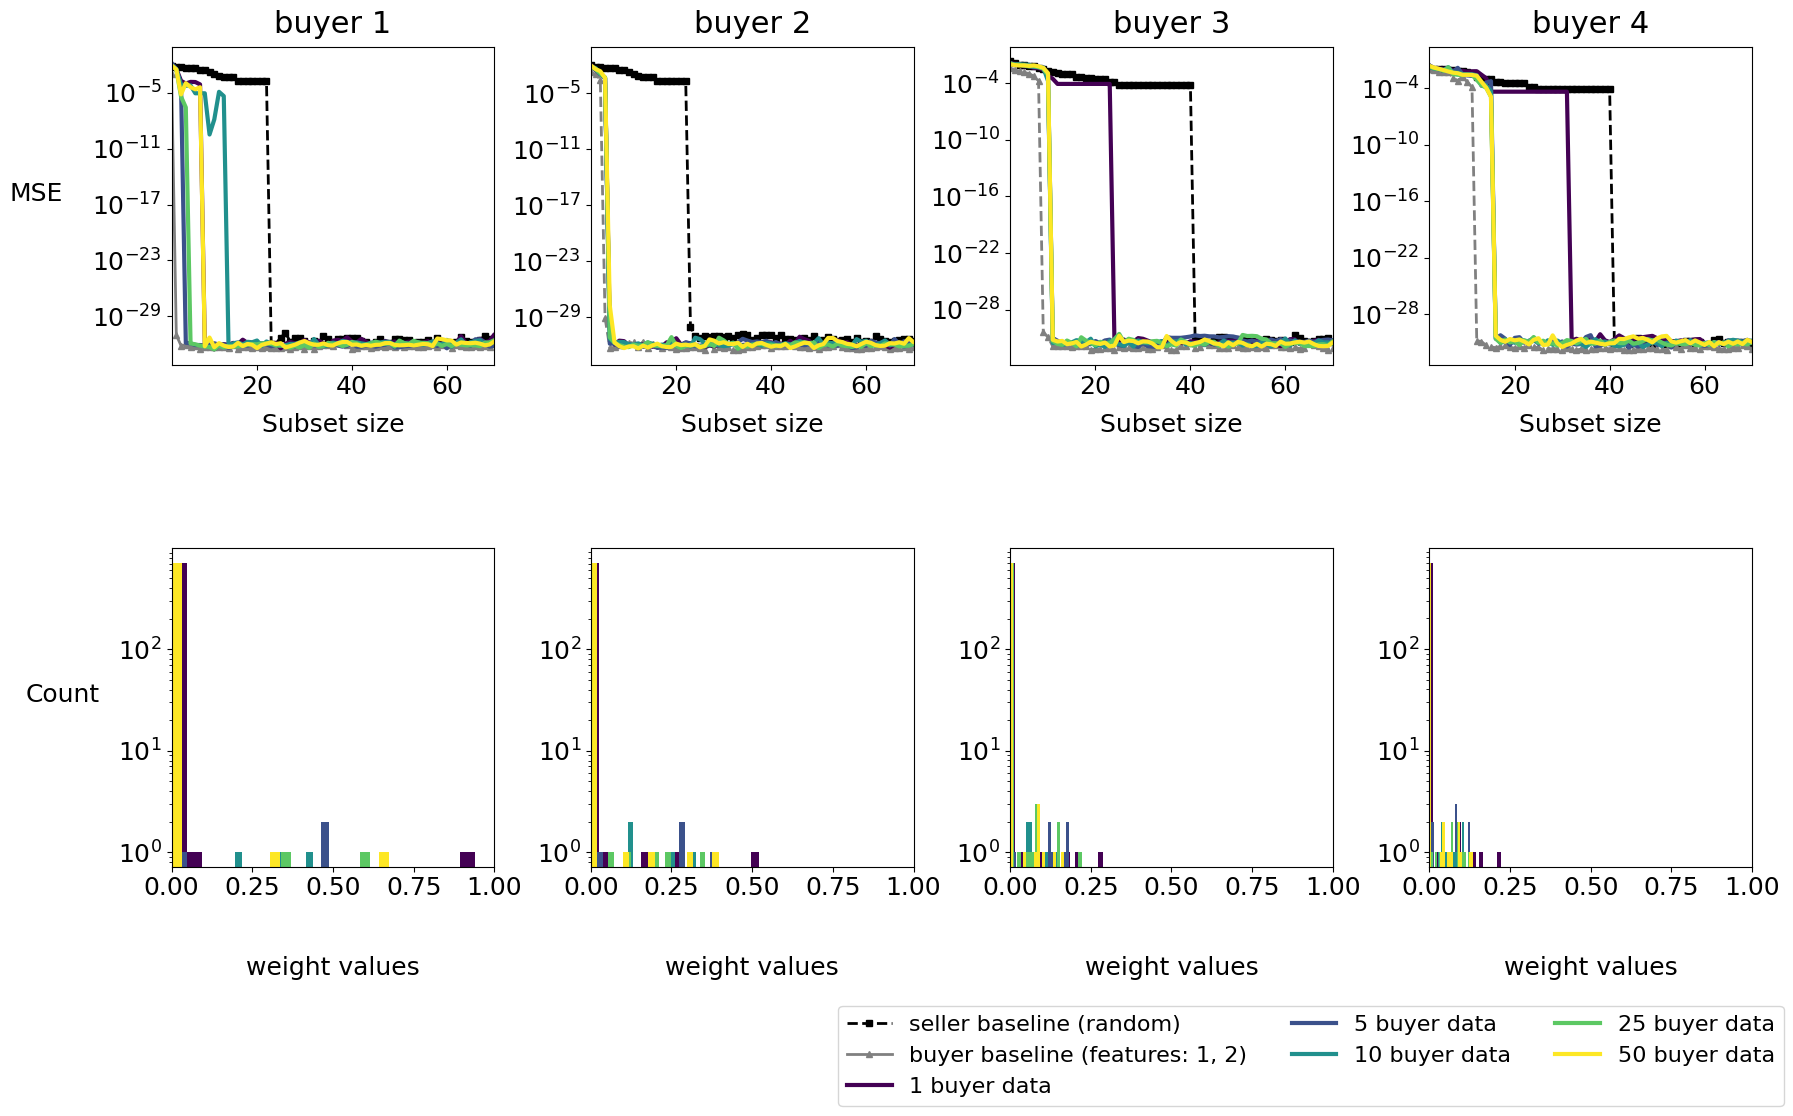

In [764]:
xlim = (2, 70)
bins = 20
lw = 3
baseline_lw = 2
markersize = 5
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(18, 10))

for i, (k, v) in enumerate(trial_buyer1_errors.items()):
    ax[0, 0].errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=lw, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
ax[0, 0].set_title('buyer 1', fontsize=22, pad=10)
ax[0, 0].plot(train_range, np.array(trial_buyer1_baselines['seller']).mean(0), marker='s', markersize=markersize, c='k', lw=baseline_lw, ls='--', label='seller baseline (random)')
ax[0, 0].plot(train_range, np.array(trial_buyer1_baselines['buyer']).mean(0), marker='^', markersize=markersize, c='gray', lw=baseline_lw, label=label)
# ax[0, 0].legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.95, 1.00), ncol=1)
ax[0, 0].set_xlabel('Subset size', fontsize=18, labelpad=10)
ax[0, 0].set_ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
ax[0, 0].tick_params(labelsize=18)
ax[0, 0].set_xlim(*xlim)
ax[0, 0].set_yscale('log')
# plt.savefig(figure_dir / f'buyer1-{dataset}.png', bbox_inches='tight')

for i, (k, v) in enumerate(buyer1_weights.items()):
    ax[1, 0].hist(v, bins=bins, color=colors[i])
ax[1, 0].set_yscale('log')
ax[1, 0].tick_params(labelsize=18)
ax[1, 0].set_xlabel('weight values', fontsize=18, rotation=0, labelpad=40)
ax[1, 0].set_ylabel('Count', fontsize=18, rotation=0, labelpad=40)
ax[1, 0].set_xlim(0, 1)

for i, (k, v) in enumerate(trial_buyer2_errors.items()):
    ax[0, 1].errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=lw, c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
ax[0, 1].set_title('buyer 2', fontsize=22, pad=10)
ax[0, 1].plot(train_range, np.array(trial_buyer2_baselines['seller']).mean(0), marker='s', markersize=markersize, c='k', lw=baseline_lw, ls='--')
ax[0, 1].plot(train_range, np.array(trial_buyer2_baselines['buyer']).mean(0), marker='^', markersize=markersize, c='gray', lw=baseline_lw, ls='--')
ax[0, 1].set_xlabel('Subset size', fontsize=18, labelpad=10)
# ax[0, 1].set_ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
ax[0, 1].tick_params(labelsize=18)
ax[0, 1].set_xlim(*xlim)
ax[0, 1].set_yscale('log')

for i, (k, v) in enumerate(buyer2_weights.items()):
    ax[1, 1].hist(v, bins=bins, color=colors[i])
ax[1, 1].set_yscale('log')
ax[1, 1].tick_params(labelsize=18)
ax[1, 1].set_xlabel('weight values', fontsize=18, rotation=0, labelpad=40)
# ax[1, 1].set_ylabel('Count', fontsize=18, rotation=0, labelpad=40)
ax[1, 1].set_xlim(0, 1)

for i, (k, v) in enumerate(trial_buyer3_errors.items()):
    ax[0, 2].errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=lw,  c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
ax[0, 2].set_title('buyer 3', fontsize=22, pad=10)
ax[0, 2].plot(train_range, np.array(trial_buyer3_baselines['seller']).mean(0), marker='s', markersize=markersize, c='k', lw=baseline_lw, ls='--')
ax[0, 2].plot(train_range, np.array(trial_buyer3_baselines['buyer']).mean(0), marker='^', markersize=markersize, c='gray', lw=baseline_lw, ls='--')
ax[0, 2].set_xlabel('Subset size', fontsize=18, labelpad=10)
# ax[0, 2].set_ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
ax[0, 2].tick_params(labelsize=18)
ax[0, 2].set_xlim(*xlim)
ax[0, 2].set_yscale('log')

for i, (k, v) in enumerate(buyer3_weights.items()):
    ax[1, 2].hist(v, bins=bins, color=colors[i])
ax[1, 2].set_yscale('log')
ax[1, 2].tick_params(labelsize=18)
ax[1, 2].set_xlabel('weight values', fontsize=18, rotation=0, labelpad=40)
# ax[1, 2].set_ylabel('Count', fontsize=18, rotation=0, labelpad=40)
ax[1, 2].set_xlim(0, 1)

for i, (k, v) in enumerate(trial_buyer4_errors.items()):
    ax[0, 3].errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=lw, c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
ax[0, 3].set_title('buyer 4', fontsize=22, pad=10)
ax[0, 3].plot(train_range, np.array(trial_buyer4_baselines['seller']).mean(0), marker='s', markersize=markersize, c='k', lw=baseline_lw, ls='--')
ax[0, 3].plot(train_range, np.array(trial_buyer4_baselines['buyer']).mean(0), marker='^', markersize=markersize, c='gray', lw=baseline_lw, ls='--')
ax[0, 3].set_xlabel('Subset size', fontsize=18, labelpad=10)
# ax[0, 3].set_ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
ax[0, 3].tick_params(labelsize=18)
ax[0, 3].set_xlim(*xlim)
ax[0, 3].set_yscale('log')

for i, (k, v) in enumerate(buyer4_weights.items()):
    ax[1, 3].hist(v, bins=bins, color=colors[i])
ax[1, 3].set_yscale('log')
ax[1, 3].tick_params(labelsize=18)
ax[1, 3].set_xlabel('weight values', fontsize=18, rotation=0, labelpad=40)
# ax[1, 3].set_ylabel('Count', fontsize=18, rotation=0, labelpad=40)
ax[1, 3].set_xlim(0, 1)

fig.tight_layout(h_pad=8)
fig.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 0.00), ncol=3)
plt.savefig(figure_dir / f'feature-{dataset}.png', bbox_inches='tight')
plt.show()

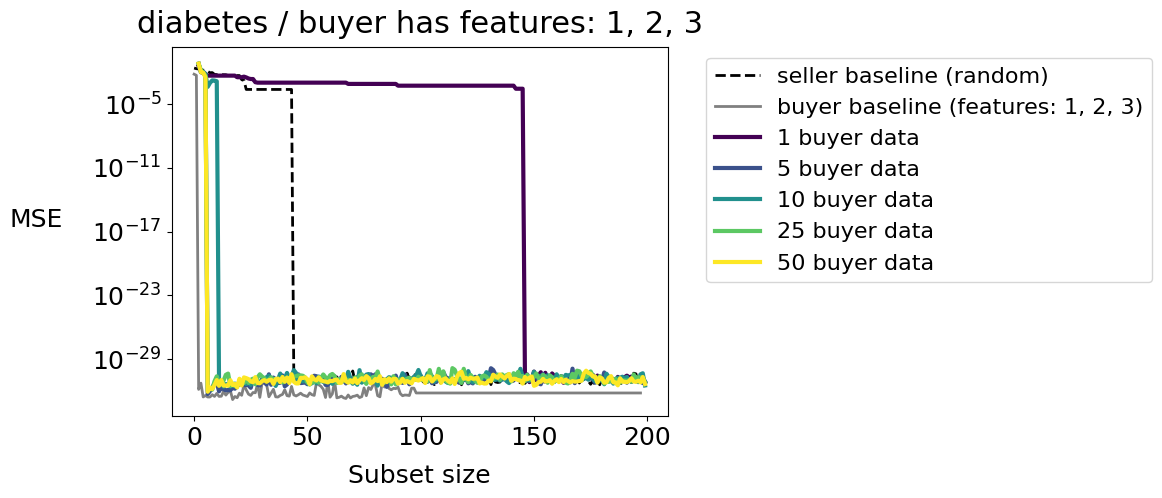

In [668]:
for i, (k, v) in enumerate(trial_buyer2_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1, 2, 3'
    label = 'buyer baseline (features: 1, 2, 3)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 1-4'
    label = 'buyer baseline (features: 1-4)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer2_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (random)')
plt.plot(np.array(trial_buyer2_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(2.00, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
plt.yscale('log')
# plt.ylim(0.0, 0.35)
# plt.ylim(0.0, 1.)
# plt.savefig(figure_dir / f'buyer2-{dataset}.png', bbox_inches='tight')

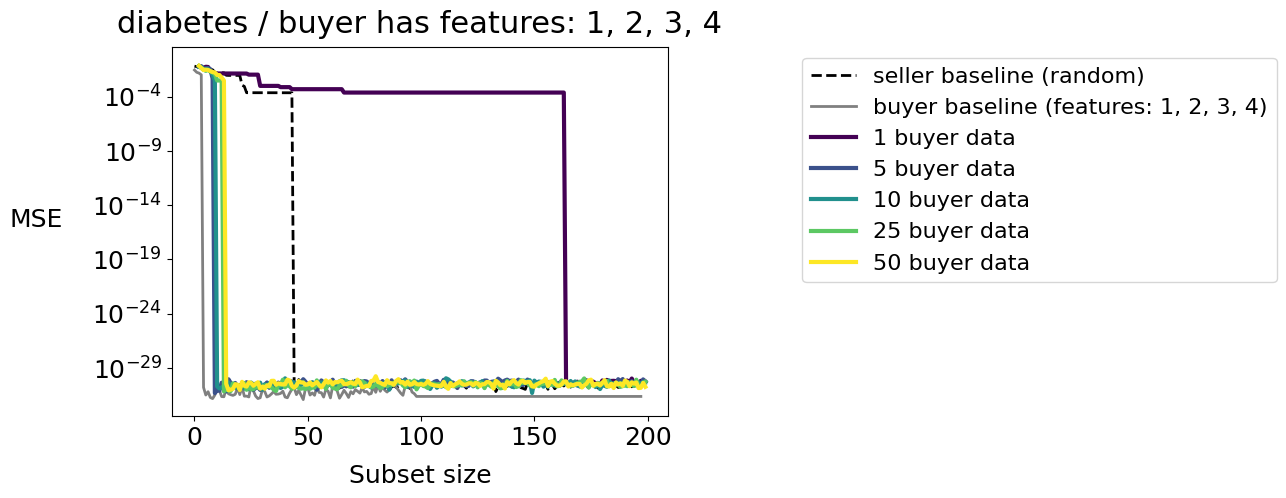

In [669]:
for i, (k, v) in enumerate(trial_buyer3_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1, 2, 3, 4'
    label = 'buyer baseline (features: 1, 2, 3, 4)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 1-8'
    label = 'buyer baseline (features: 1-8)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer3_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (random)')
plt.plot(np.array(trial_buyer3_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(2.25, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
plt.yscale('log')
# plt.ylim(0.0, 0.35)
# plt.ylim(0.0, 1.)
# plt.savefig(figure_dir / f'buyer3-{dataset}.png', bbox_inches='tight')

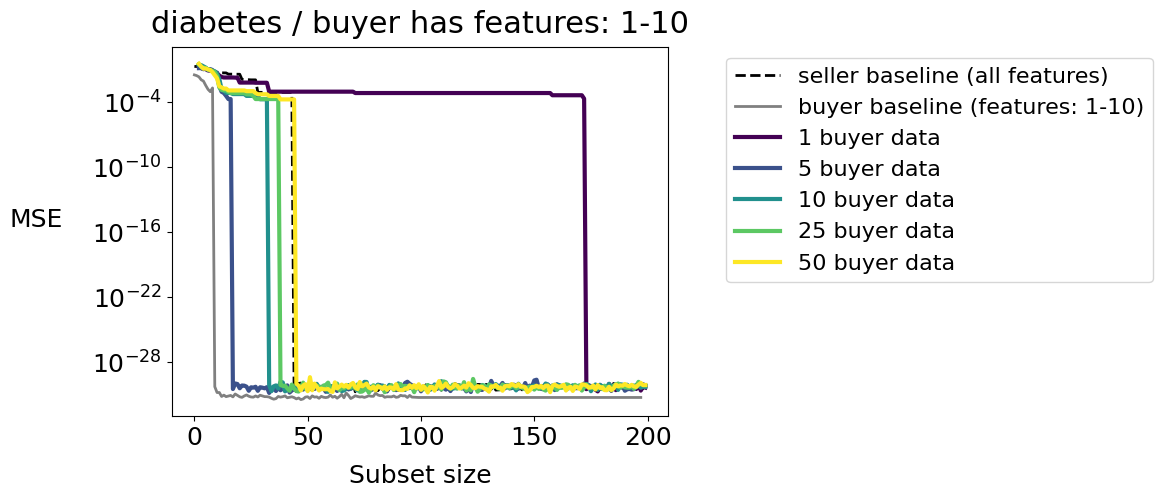

In [671]:
for i, (k, v) in enumerate(trial_buyer4_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1-10'
    label = 'buyer baseline (features: 1-10)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 1-10'
    label = 'buyer baseline (features: 1-10)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer4_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (all features)')
plt.plot(np.array(trial_buyer4_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(2.0, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
plt.yscale('log')
# plt.ylim(0.01, 1.0)
# plt.savefig(figure_dir / f'buyer4-{dataset}.png', bbox_inches='tight')

* each seller has different features
* concatenate along feature dimension not sample dimesnion
* ~~check that trace version gives same answer as loop~~


In [5]:
X_0 = 1 + np.arange(0, 400).reshape(40, 10) / 100
w = 1 + np.arange(0, 100) / 100
X = 1 + np.arange(0, 1000).reshape(100, 10) / 100

In [6]:
np.trace(X_0 @ np.linalg.inv(np.sum(np.stack([w[i] * X[[i]].T @ X[[i]] for i in range(X.shape[0])]), 0)) @ X_0.T)

0.7333284606933594

In [7]:
np.sum([X_0[j] @ np.linalg.inv(np.sum(np.stack([w[i] * X[[i]].T @ X[[i]] for i in range(X.shape[0])]), 0)) @ X_0[j].T for j in range(X_0.shape[0])])

0.734410120801898

## setup datasets

In [299]:
random_state = 0
num_features = 2
num_features = 5
# num_features = 10

In [300]:
def scatter(x, y, best_fit=True):
    plt.scatter(x, y, marker='.')
    if best_fit:
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b, 'k')
    plt.show()

**diabetes**

In [362]:
data = load_diabetes()
diabetes_x = data["data"][:, :num_features]
diabetes_y = data["target"]

MMS = MinMaxScaler()
diabetes_scaled_x = MMS.fit_transform(diabetes_x)
diabetes_scaled_y = MMS.fit_transform(diabetes_y[:, None]).flatten()

_diabetes_train_x, _diabetes_test_x, _diabetes_train_y, _diabetes_test_y = train_test_split(diabetes_scaled_x, diabetes_scaled_y, test_size=0.43, random_state=random_state)
_diabetes_buyer_x, _diabetes_seller_x, _diabetes_buyer_y, _diabetes_seller_y = train_test_split(_diabetes_train_x, _diabetes_train_y, train_size=0.4, random_state=random_state)
_diabetes_seller_x.shape, _diabetes_buyer_x.shape, _diabetes_test_x.shape

((151, 5), (100, 5), (191, 5))

**forest fires**

In [148]:
fire_df = pd.read_csv('../data/forestfires.csv')
fire_df.month = pd.get_dummies(fire_df.month).values.argmax(1)
fire_df.day = pd.get_dummies(fire_df.day).values.argmax(1)
fire_df.drop(columns=['month', 'day'], inplace=True)

fire_x = fire_df.iloc[:, :num_features]
fire_y = fire_df.area.values

MMS = MinMaxScaler()
fire_scaled_x = MMS.fit_transform(fire_x)
fire_scaled_y = MMS.fit_transform(fire_y[:, None]).flatten()

_fire_train_x, _fire_test_x, _fire_train_y, _fire_test_y = train_test_split(fire_scaled_x, fire_scaled_y, test_size=0.5, random_state=random_state)
_fire_buyer_x, _fire_seller_x, _fire_buyer_y, _fire_seller_y = train_test_split(_fire_train_x, _fire_train_y, train_size=0.4, random_state=random_state)
_fire_seller_x.shape, _fire_buyer_x.shape, _fire_test_x.shape

NameError: name 'num_features' is not defined

In [149]:
fire_df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


**housing**

In [415]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing_df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

exclude = ['CHAS']
housing_df = housing_df.drop(columns=exclude)
housing_x = housing_df.iloc[:, :num_features].values
housing_y = housing_df.MEDV.values

MMS = MinMaxScaler()
housing_scaled_x = MMS.fit_transform(housing_x)
housing_scaled_y = MMS.fit_transform(housing_y[:, None]).flatten()

_housing_train_x, _housing_test_x, _housing_train_y, _housing_test_y = train_test_split(housing_scaled_x, housing_scaled_y, test_size=0.5, random_state=random_state)
_housing_buyer_x, _housing_seller_x, _housing_buyer_y, _housing_seller_y = train_test_split(_housing_train_x, _housing_train_y, train_size=0.4, random_state=random_state)
_housing_seller_x.shape, _housing_buyer_x.shape, _housing_test_x.shape

((152, 5), (101, 5), (253, 5))

**wine**

In [366]:
wine_df = pd.read_csv('../data/winequality-red.csv', sep=';')
wine_df

wine_x = wine_df.iloc[:, :num_features]
wine_y = wine_df.quality.values

MMS = MinMaxScaler()
wine_scaled_x = MMS.fit_transform(wine_x)
wine_scaled_y = MMS.fit_transform(wine_y[:, None]).flatten()

_wine_train_x, _wine_test_x, _wine_train_y, _wine_test_y = train_test_split(wine_scaled_x, wine_scaled_y, test_size=0.84, random_state=random_state)
_wine_buyer_x, _wine_seller_x, _wine_buyer_y, _wine_seller_y = train_test_split(_wine_train_x, _wine_train_y, train_size=0.4, random_state=random_state)
_wine_seller_x.shape, _wine_buyer_x.shape, _wine_test_x.shape

((153, 5), (102, 5), (1344, 5))

**random**

In [370]:
_random_seller_x = MMS.fit_transform(np.random.randn(150, num_features))
_random_buyer_x = MMS.fit_transform(np.random.randn(100, num_features))
_random_test_x = MMS.fit_transform(np.random.randn(300, num_features))
_random_seller_y = MMS.fit_transform(np.random.randn(150)[:, None]).flatten()
_random_buyer_y = MMS.fit_transform(np.random.randn(100)[:, None]).flatten()
_random_test_y = MMS.fit_transform(np.random.randn(300)[:, None]).flatten()

In [371]:
diabetes_seller_x = np.pad(_diabetes_seller_x, ((0, 0), (0, 4*num_features)))
diabetes_buyer_x = np.pad(_diabetes_buyer_x, ((0, 0), (0, 4*num_features)))
diabetes_test_x = np.pad(_diabetes_test_x, ((0, 0), (0, 4*num_features)))
fire_seller_x = np.pad(_fire_seller_x, ((0, 0), (num_features, 3*num_features)))
fire_buyer_x = np.pad(_fire_buyer_x, ((0, 0), (num_features, 3*num_features)))
fire_test_x = np.pad(_fire_test_x, ((0, 0), (num_features, 3*num_features)))
housing_seller_x = np.pad(_housing_seller_x, ((0, 0), (2*num_features, 2*num_features)))
housing_buyer_x = np.pad(_housing_buyer_x, ((0, 0), (2*num_features, 2*num_features)))
housing_test_x = np.pad(_housing_test_x, ((0, 0), (2*num_features, 2*num_features)))
wine_seller_x = np.pad(_wine_seller_x, ((0, 0), (3*num_features, 1*num_features)))
wine_buyer_x = np.pad(_wine_buyer_x, ((0, 0), (3*num_features, 1*num_features)))
wine_test_x = np.pad(_wine_test_x, ((0, 0), (3*num_features, 1*num_features)))
random_seller_x = np.pad(_random_seller_x, ((0, 0), (4*num_features, 0)))
random_buyer_x = np.pad(_random_buyer_x, ((0, 0), (4*num_features, 0)))
random_test_x = np.pad(_random_test_x, ((0, 0), (4*num_features, 0)))

In [328]:
# seller_data_x = np.concatenate([
#     diabetes_seller_x,
#     fire_seller_x,
#     housing_seller_x,
#     wine_seller_x,
#     random_seller_x,
# ])
seller_data_x = np.concatenate([
    np.pad(diabetes_seller_x, ((0, 0), (0, 4*num_features))),
    np.pad(fire_seller_x, ((0, 0), (num_features, 3*num_features))),
    np.pad(housing_seller_x, ((0, 0), (2*num_features, 2*num_features))),
    np.pad(wine_seller_x, ((0, 0), (3*num_features, 1*num_features))),
    np.pad(random_seller_x, ((0, 0), (4*num_features, 0))),
])

seller_data_y = np.concatenate([
    diabetes_seller_y,
    fire_seller_y,
    housing_seller_y,
    wine_seller_y,
    random_seller_y,
])

np.random.seed(0)
perm = np.random.permutation(np.arange(seller_data_x.shape[0]))
inv_perm = np.empty_like(perm)
inv_perm[perm] = np.arange(perm.shape[0])
seller_data_x = seller_data_x[perm]
seller_data_y = seller_data_y[perm]

## experimental design

In [339]:
import cvxpy as cp

def optimize_seller_weights(seller_data, buyer_data, lam1=1, lam2=1):
    
    num_seller_data = seller_data.shape[0]
    seller_weights = cp.Variable((num_seller_data, 1))
    
    def objective(seller_weights, seller_data, buyer_data, lam1=lam1, lam2=lam2):
        cost = cp.matrix_frac(
                buyer_data.T,
                cp.sum([
                    seller_weights[i] * seller_data[i][None].T @ seller_data[i][None] 
                     for i in range(seller_data.shape[0])
                ])
            ) / buyer_data.shape[0]
        reg1 = cp.norm1(seller_weights)
        reg2 = cp.pnorm(seller_weights)
        # loss = cost + lam1 * reg1 + lam2 * reg2
        loss = cost 
        return loss
    
    # constraints = [seller_weights >= 0]
    constraints = [seller_weights >= 0, sum(seller_weights) == 1]
    prob = cp.Problem(cp.Minimize(objective(seller_weights, seller_data, buyer_data)), constraints)
    start = perf_counter()
    prob.solve()
    end = perf_counter()
    runtime = end - start
    print(prob.status, f"{runtime:.1f}\t{prob.value=:.2f}")
    return seller_weights.value.flatten()


In [341]:
# lam1 = 3
# lam2 = 5
lam1 = 15
lam2 = 15

diabetes_weights = {}
fire_weights = {}
housing_weights = {}
wine_weights = {}
random_weights = {}

# for k in tqdm(np.arange(0, 101, 10)):
for k in tqdm(np.arange(0, 101, 10)):
    if k == 0: k = 1
    print(k)
    diabetes_weights[k] = optimize_seller_weights(seller_data_x, diabetes_buyer_x[:k], lam1=lam1, lam2=lam2)
    fire_weights[k] = optimize_seller_weights(seller_data_x, fire_buyer_x[:k], lam1=lam1, lam2=lam2)
    housing_weights[k] = optimize_seller_weights(seller_data_x, housing_buyer_x[:k], lam1=lam1, lam2=lam2)
    wine_weights[k] = optimize_seller_weights(seller_data_x, wine_buyer_x[:k], lam1=lam1, lam2=lam2)
    random_weights[k] = optimize_seller_weights(seller_data_x, random_buyer_x[:k], lam1=lam1, lam2=lam2)

  0%|          | 0/11 [00:00<?, ?it/s]

1
optimal 5.4	prob.value=1.00
optimal 4.8	prob.value=1.10
optimal 8.1	prob.value=0.86
optimal 1.7	prob.value=0.40
optimal 2.9	prob.value=2.16
10
optimal 3.5	prob.value=2.66
optimal 8.8	prob.value=3.46
optimal 1.8	prob.value=1.16
optimal 6.6	prob.value=1.62
optimal 3.0	prob.value=3.36
20
optimal 3.2	prob.value=2.45
optimal 4.6	prob.value=3.43
optimal 2.7	prob.value=1.20
optimal 4.1	prob.value=1.89
optimal 4.5	prob.value=3.34
30
optimal 2.9	prob.value=2.59
optimal 6.1	prob.value=3.25
optimal 2.8	prob.value=1.88
optimal 20.0	prob.value=1.84
optimal 5.7	prob.value=3.21
40
optimal 4.7	prob.value=2.60
optimal 5.8	prob.value=3.29
optimal 2.5	prob.value=1.81
optimal 26.6	prob.value=1.78
optimal 4.5	prob.value=3.37
50
optimal 7.8	prob.value=2.52
optimal 12.3	prob.value=3.34
optimal 8.4	prob.value=1.88
optimal 33.1	prob.value=1.67
optimal 3.8	prob.value=3.29
60
optimal 4.7	prob.value=2.52
optimal 11.0	prob.value=3.39
optimal 4.2	prob.value=1.72
optimal 19.3	prob.value=1.85
optimal 7.1	prob.value

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 142.2	prob.value=2.01
optimal 6.2	prob.value=3.41
90
optimal 11.8	prob.value=2.57
optimal 54.8	prob.value=3.30
optimal 9.0	prob.value=1.70
optimal 71.5	prob.value=1.93
optimal 38.6	prob.value=3.46
100
optimal 32.6	prob.value=2.58
optimal 31.6	prob.value=3.26
optimal 10.8	prob.value=1.83
optimal_inaccurate 201.4	prob.value=1.89
optimal 16.4	prob.value=3.44


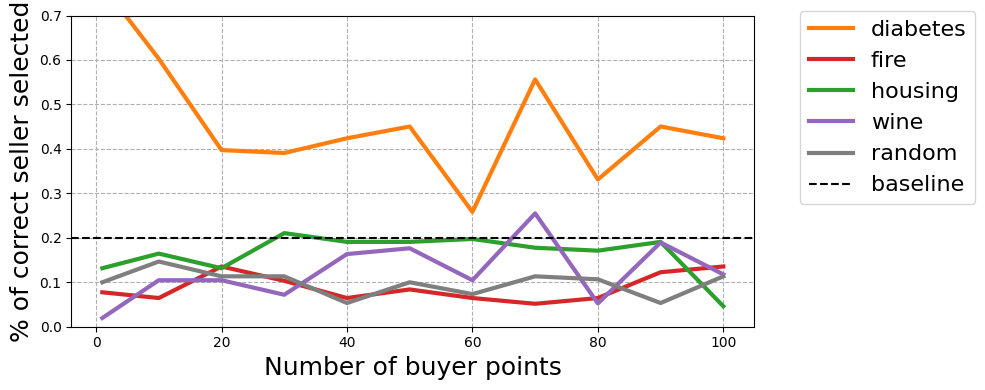

In [382]:
m = seller_data_x.shape[0]

ylim = (0.0, 0.70)

m_diabetes = diabetes_seller_x.shape[0]
num_diabetes_selected = []
for k in diabetes_weights.keys():
    num_diabetes_selected.append((diabetes_weights[k][inv_perm].argsort()[::-1][:m_diabetes] < m_diabetes).sum() / m_diabetes)
    
m_fire = fire_seller_x.shape[0]
num_fire_selected = []
for k in fire_weights.keys():
    num_fire_selected.append((fire_weights[k][inv_perm].argsort()[::-1][:m_fire] < m_fire).sum() / m_fire)
    
m_housing = housing_seller_x.shape[0]
num_housing_selected = []
for k in housing_weights.keys():
    num_housing_selected.append((housing_weights[k][inv_perm].argsort()[::-1][:m_housing] < m_housing).sum() / m_housing)
    
m_wine = wine_seller_x.shape[0]
num_wine_selected = []
for k in wine_weights.keys():
    num_wine_selected.append((wine_weights[k][inv_perm].argsort()[::-1][:m_wine] < m_wine).sum() / m_wine)
    
m_random = random_seller_x.shape[0]
num_random_selected = []
for k in random_weights.keys():
    num_random_selected.append((random_weights[k][inv_perm].argsort()[::-1][:m_random] < m_random).sum() / m_random)
    
fig, ax = plt.subplots(nrows=1, figsize=(10, 4))
ax.plot(diabetes_weights.keys(), num_diabetes_selected, label='diabetes', c='C1', lw=3)
ax.plot(fire_weights.keys(), num_fire_selected, label='fire', c='C3', lw=3)
ax.plot(housing_weights.keys(), num_housing_selected, label='housing', c='C2', lw=3)
ax.plot(wine_weights.keys(), num_wine_selected, label='wine', c='C4', lw=3)
ax.plot(random_weights.keys(), num_random_selected, label='random', c='C7', lw=3)
ax.axhline(0.2, c='k', ls='--', label='baseline')
ax.set_xlabel('Number of buyer points', fontsize=18)
ax.set_ylabel('% of correct seller selected', fontsize=18)
ax.legend(fontsize=16, loc='upper right')
ax.set_ylim(*ylim)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()
plt.grid(ls='--')
plt.savefig(figure_dir / 'selected.png', bbox_inches='tight')

In [348]:
def fit_predict(train_data, train_targets, test_data, test_targets):
    LR = LinearRegression()
    LR.fit(train_data, train_targets)
    test_pred = LR.predict(test_data)
    return mean_squared_error(test_targets, test_pred)

In [352]:
diabetes_test_x.shape

(191, 25)

In [355]:
diabetes_seller_x.shape

(151, 5)

In [372]:
subset_range = [int(x) for x in np.linspace(5, 150, 50)]


diabetes_baseline_all = fit_predict(seller_data_x, seller_data_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_fire = fit_predict(fire_seller_x, fire_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_wine = fit_predict(wine_seller_x, wine_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_baseline_random = fit_predict(random_seller_x, random_seller_y, diabetes_test_x, diabetes_test_y)
diabetes_results = defaultdict(list)
for k, v in diabetes_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        # weights = v[indices]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        diabetes_results[k].append(fit_predict(seller_subset_x, seller_subset_y, diabetes_test_x, diabetes_test_y))
        
fire_baseline_all = fit_predict(seller_data_x, seller_data_y, fire_test_x, fire_test_y)
fire_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, fire_test_x, fire_test_y)
fire_baseline_fire = fit_predict(fire_seller_x, fire_seller_y, fire_test_x, fire_test_y)
fire_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, fire_test_x, fire_test_y)
fire_baseline_wine = fit_predict(wine_seller_x, wine_seller_y, fire_test_x, fire_test_y)
fire_baseline_random = fit_predict(random_seller_x, random_seller_y, fire_test_x, fire_test_y)
fire_results = defaultdict(list)
for k, v in fire_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        # weights = v[indices]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        fire_results[k].append(fit_predict(seller_subset_x, seller_subset_y, fire_test_x, fire_test_y))
        
housing_baseline_all = fit_predict(seller_data_x, seller_data_y, housing_test_x, housing_test_y)
housing_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, housing_test_x, housing_test_y)
housing_baseline_fire = fit_predict(fire_seller_x, fire_seller_y, housing_test_x, housing_test_y)
housing_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, housing_test_x, housing_test_y)
housing_baseline_wine = fit_predict(wine_seller_x, wine_seller_y, housing_test_x, housing_test_y)
housing_baseline_random = fit_predict(random_seller_x, random_seller_y, housing_test_x, housing_test_y)

housing_results = defaultdict(list)

for k, v in housing_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        housing_results[k].append(fit_predict(seller_subset_x, seller_subset_y, housing_test_x, housing_test_y))
        
wine_baseline_all = fit_predict(seller_data_x, seller_data_y, wine_test_x, wine_test_y)
wine_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, wine_test_x, wine_test_y)
wine_baseline_fire = fit_predict(fire_seller_x, fire_seller_y, wine_test_x, wine_test_y)
wine_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, wine_test_x, wine_test_y)
wine_baseline_wine = fit_predict(wine_seller_x, wine_seller_y, wine_test_x, wine_test_y)
wine_baseline_random = fit_predict(random_seller_x, random_seller_y, wine_test_x, wine_test_y)
wine_results = defaultdict(list)
for k, v in wine_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        # weights = v[indices]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        wine_results[k].append(fit_predict(seller_subset_x, seller_subset_y, wine_test_x, wine_test_y))
        
random_baseline_all = fit_predict(seller_data_x, seller_data_y, random_test_x, random_test_y)
random_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, random_test_x, random_test_y)
random_baseline_fire = fit_predict(fire_seller_x, fire_seller_y, random_test_x, random_test_y)
random_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, random_test_x, random_test_y)
random_baseline_wine = fit_predict(wine_seller_x, wine_seller_y, random_test_x, random_test_y)
random_baseline_random = fit_predict(random_seller_x, random_seller_y, random_test_x, random_test_y)

random_results = defaultdict(list)

for k, v in random_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        random_results[k].append(fit_predict(seller_subset_x, seller_subset_y, random_test_x, random_test_y))

In [373]:
precision = 3
print("MSE")
print('diabetes', diabetes_baseline_diabetes.round(precision))
print('fire', fire_baseline_fire.round(precision))
print('housing', housing_baseline_housing.round(precision))
print('wine', wine_baseline_wine.round(precision))
print('random', random_baseline_random.round(precision))

MSE
diabetes 0.035
fire 0.004
housing 0.028
wine 0.023
random 0.026


In [374]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(diabetes_results)).astype(int)]
lw = 4

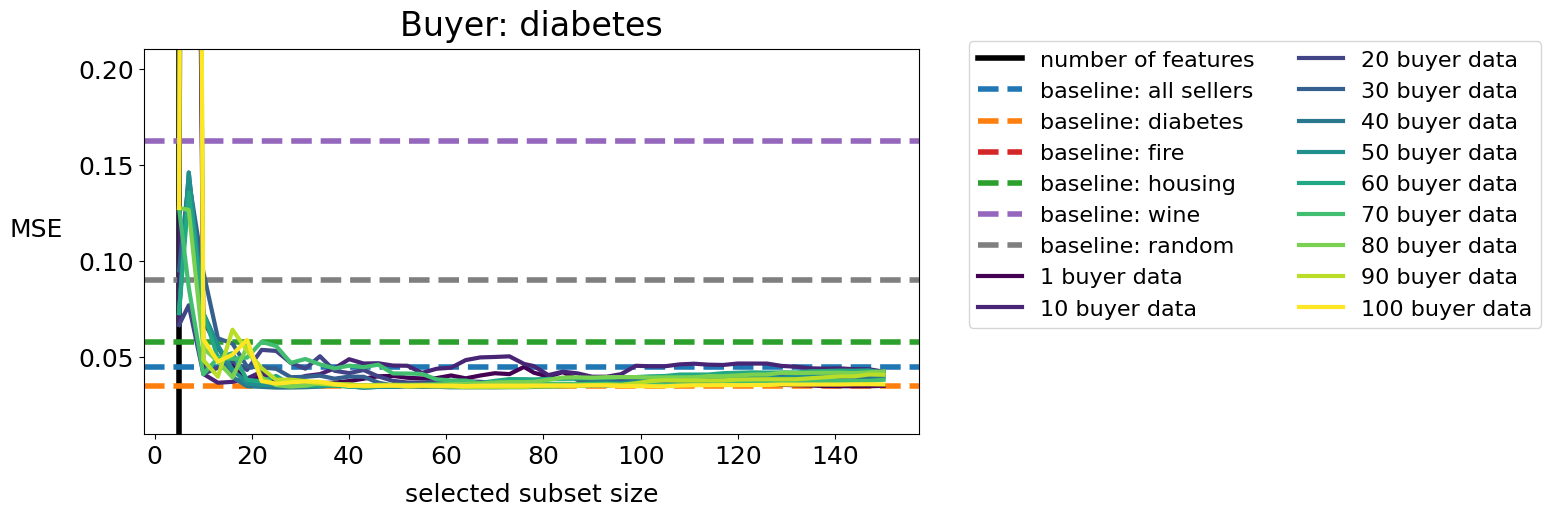

In [383]:
plt.figure(figsize=(10, 5))
plt.axvline(num_features, ls='-', label='number of features', lw=lw, c='k')
plt.axhline(diabetes_baseline_all, ls='--', label='baseline: all sellers', lw=lw, c='C0',)
plt.axhline(diabetes_baseline_diabetes, ls='--', label='baseline: diabetes', lw=lw, c='C1',)
plt.axhline(diabetes_baseline_fire, ls='--', label='baseline: fire', lw=lw, c='C3',)
plt.axhline(diabetes_baseline_housing, ls='--', label='baseline: housing', lw=lw, c='C2',)
plt.axhline(diabetes_baseline_wine, ls='--', label='baseline: wine', lw=lw, c='C4',)
plt.axhline(diabetes_baseline_random, ls='--', label='baseline: random', lw=lw, c='C7',)
for i, (k, v) in enumerate(diabetes_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05), ncol=2)
plt.title('Buyer: diabetes', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=30)
# plt.ylim(2000, 30000)
plt.ylim(0.01, 0.21)
plt.tick_params(labelsize=18)
plt.savefig(figure_dir / 'diabetes.png', bbox_inches='tight')

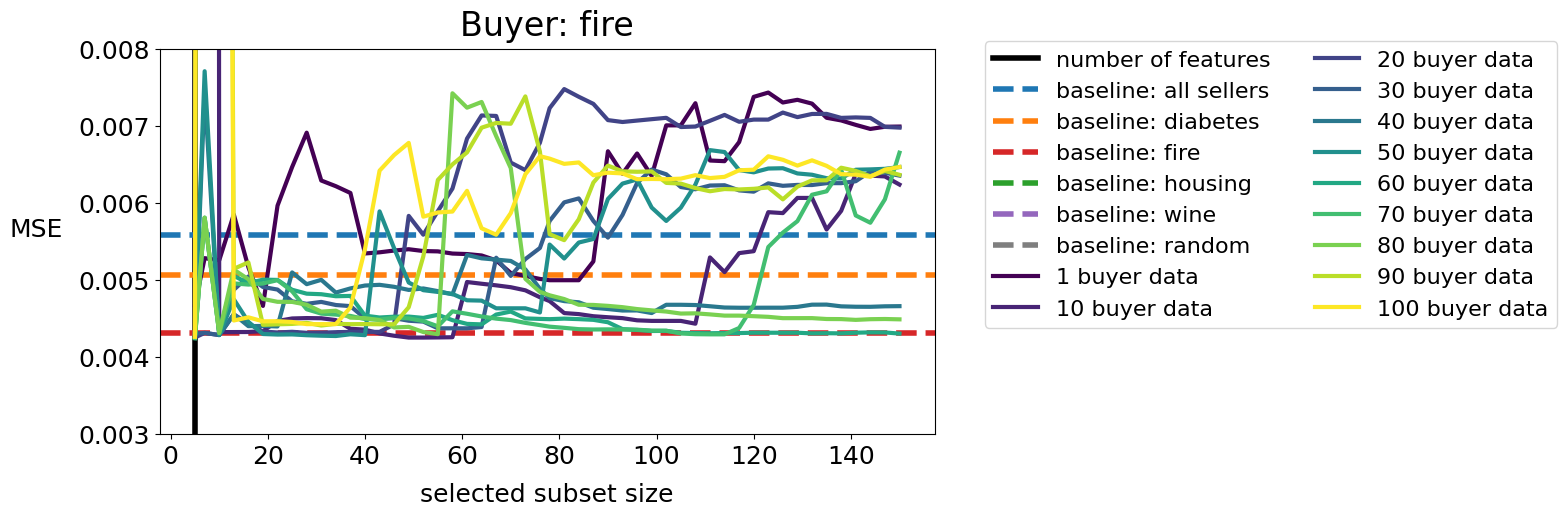

In [398]:
plt.figure(figsize=(10, 5))
plt.axvline(num_features, ls='-', label='number of features', lw=lw, c='k')
plt.axhline(fire_baseline_all, ls='--', label='baseline: all sellers', lw=lw, c='C0',)
plt.axhline(fire_baseline_diabetes, ls='--', label='baseline: diabetes', lw=lw, c='C1',)
plt.axhline(fire_baseline_fire, ls='--', label='baseline: fire', lw=lw, c='C3',)
plt.axhline(fire_baseline_housing, ls='--', label='baseline: housing', lw=lw, c='C2',)
plt.axhline(fire_baseline_wine, ls='--', label='baseline: wine', lw=lw, c='C4',)
plt.axhline(fire_baseline_random, ls='--', label='baseline: random', lw=lw, c='C7',)
for i, (k, v) in enumerate(fire_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05), ncol=2)
plt.title('Buyer: fire', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=30)
plt.ylim(0.003, 0.008)
# plt.yscale('log')
plt.tick_params(labelsize=18)
plt.savefig(figure_dir / 'fire.png', bbox_inches='tight')

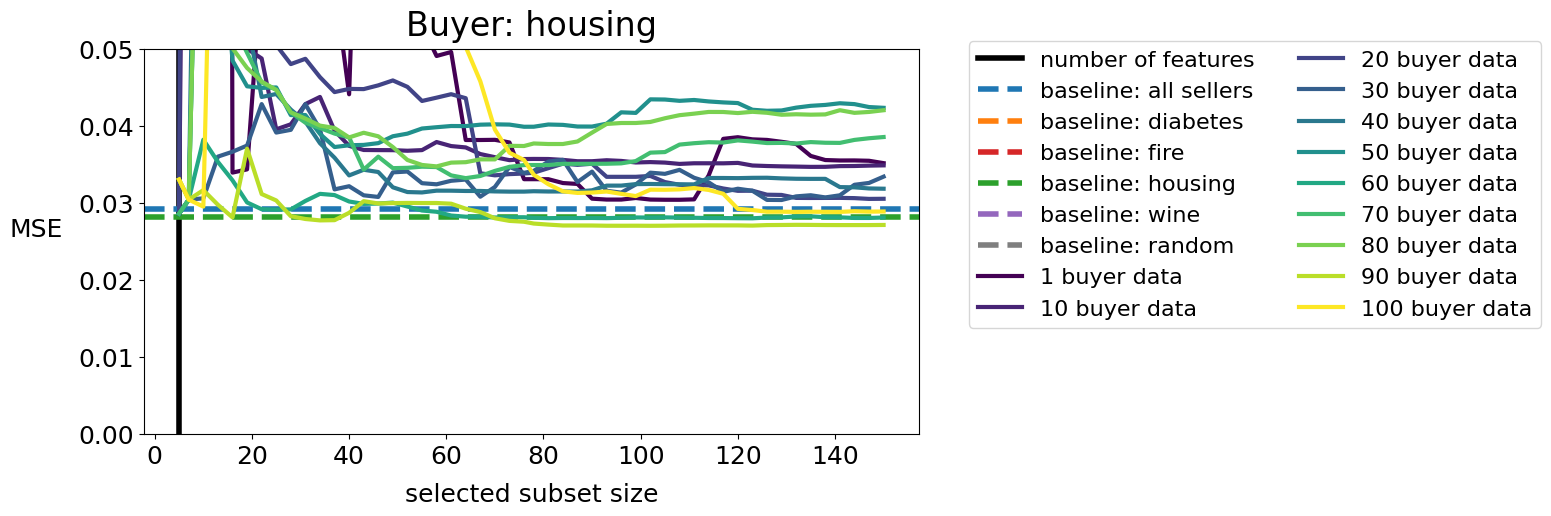

In [396]:
plt.figure(figsize=(10, 5))
plt.axvline(num_features, ls='-', label='number of features', lw=lw, c='k')
plt.axhline(housing_baseline_all, ls='--', label='baseline: all sellers', lw=lw, c='C0',)
plt.axhline(housing_baseline_diabetes, ls='--', label='baseline: diabetes', lw=lw, c='C1',)
plt.axhline(housing_baseline_fire, ls='--', label='baseline: fire', lw=lw, c='C3',)
plt.axhline(housing_baseline_housing, ls='--', label='baseline: housing', lw=lw, c='C2',)
plt.axhline(housing_baseline_wine, ls='--', label='baseline: wine', lw=lw, c='C4',)
plt.axhline(housing_baseline_random, ls='--', label='baseline: random', lw=lw, c='C7',)
for i, (k, v) in enumerate(housing_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05), ncol=2)
plt.title('Buyer: housing', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=30)
# plt.yscale('log')
# plt.ylim(50, 22000)
plt.ylim(0, 0.05)
plt.tick_params(labelsize=18)
plt.savefig(figure_dir / 'housing.png', bbox_inches='tight')

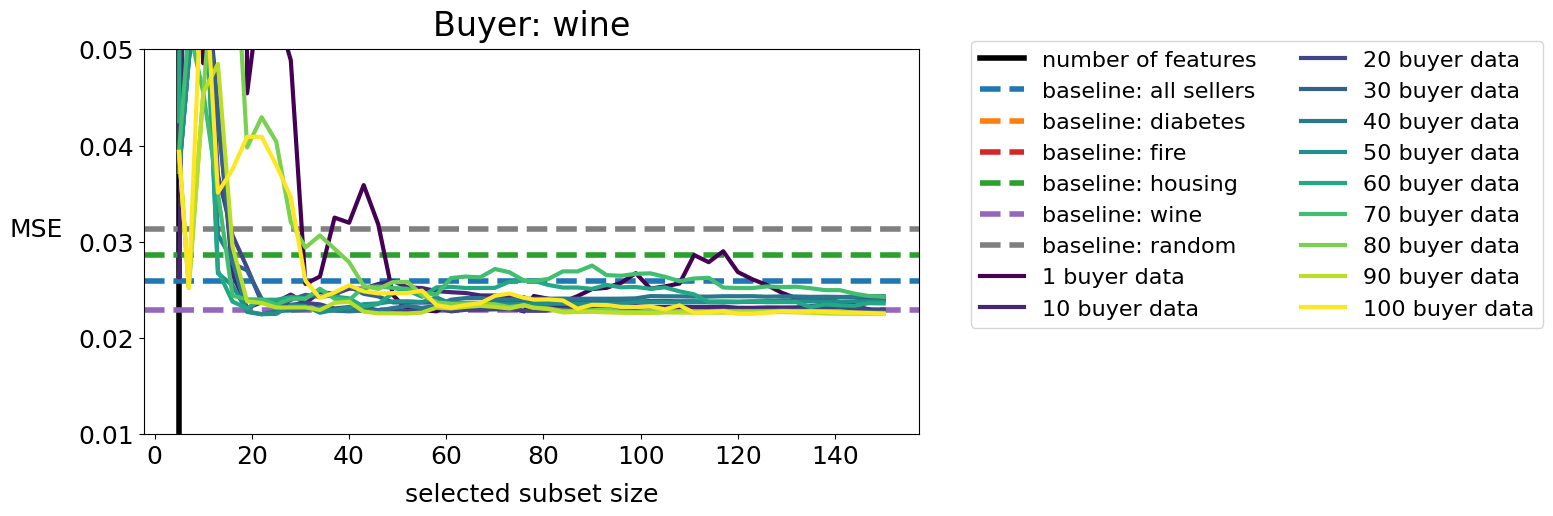

In [400]:
plt.figure(figsize=(10, 5))
plt.axvline(num_features, ls='-', label='number of features', lw=lw, c='k')
plt.axhline(wine_baseline_all, ls='--', label='baseline: all sellers', lw=lw, c='C0',)
plt.axhline(wine_baseline_diabetes, ls='--', label='baseline: diabetes', lw=lw, c='C1',)
plt.axhline(wine_baseline_fire, ls='--', label='baseline: fire', lw=lw, c='C3',)
plt.axhline(wine_baseline_housing, ls='--', label='baseline: housing', lw=lw, c='C2',)
plt.axhline(wine_baseline_wine, ls='--', label='baseline: wine', lw=lw, c='C4',)
plt.axhline(wine_baseline_random, ls='--', label='baseline: random', lw=lw, c='C7',)
for i, (k, v) in enumerate(wine_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.82, 1.05), ncol=2)
plt.title('Buyer: wine', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=30)
plt.ylim(0.01, 0.05)
plt.tick_params(labelsize=18)
plt.savefig(figure_dir / 'wine.png', bbox_inches='tight')

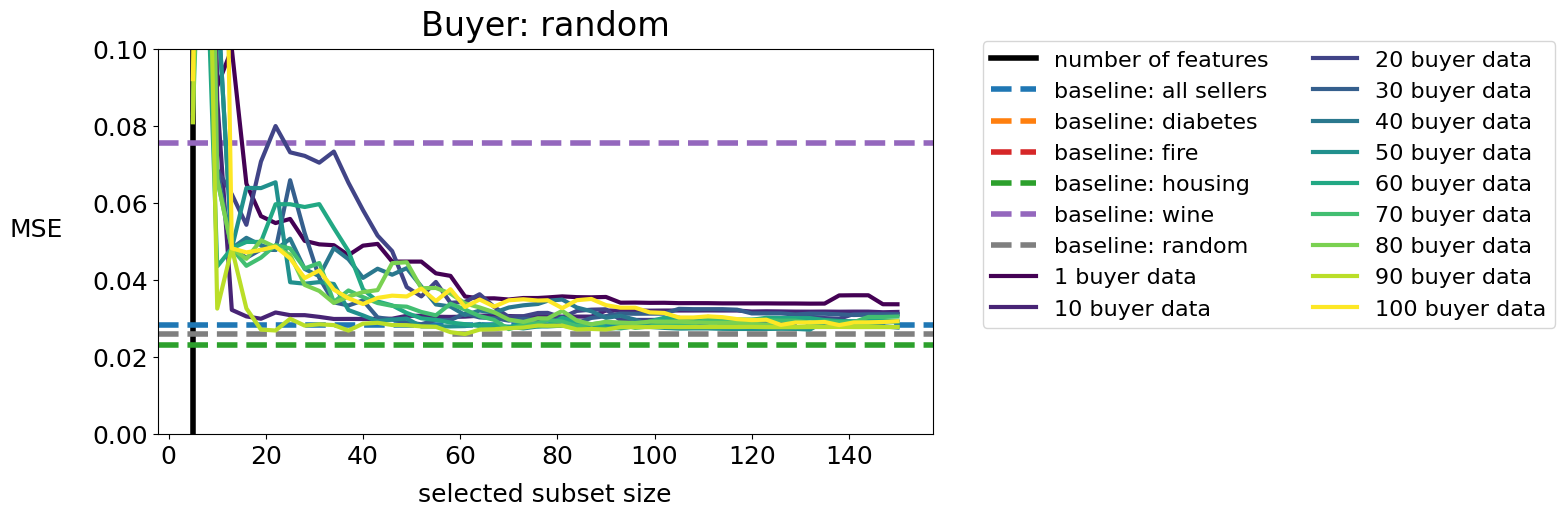

In [387]:
plt.figure(figsize=(10, 5))
plt.axvline(num_features, ls='-', label='number of features', lw=lw, c='k')
plt.axhline(random_baseline_all, ls='--', label='baseline: all sellers', lw=lw, c='C0',)
plt.axhline(random_baseline_diabetes, ls='--', label='baseline: diabetes', lw=lw, c='C1',)
plt.axhline(random_baseline_fire, ls='--', label='baseline: fire', lw=lw, c='C3',)
plt.axhline(random_baseline_housing, ls='--', label='baseline: housing', lw=lw, c='C2',)
plt.axhline(random_baseline_wine, ls='--', label='baseline: wine', lw=lw, c='C4',)
plt.axhline(random_baseline_random, ls='--', label='baseline: random', lw=lw, c='C7',)
for i, (k, v) in enumerate(random_results.items()):
    plt.plot(subset_range, v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05), ncol=2)
plt.title('Buyer: random', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
# plt.yscale('log')
plt.ylim(0.0, 0.1)
plt.tick_params(labelsize=18)
plt.savefig(figure_dir / 'random.png', bbox_inches='tight')

## Ablate $\lambda$ regularization

In [206]:
# num_buyer = 100
num_buyer = 50

lambda_1_range = [0.1, 1, 5, 10, 15]
lambda_2_range = [1, 5, 10, 15, 20]

diabetes_lambda_weights = defaultdict(dict)
fire_lambda_weights = defaultdict(dict)
housing_lambda_weights = defaultdict(dict)
wine_lambda_weights = defaultdict(dict)
random_lambda_weights = defaultdict(dict)

for lam1, lam2 in tqdm(product(lambda_1_range, lambda_2_range), total=len(lambda_1_range) * len(lambda_2_range)):
    diabetes_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, diabetes_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)
    fire_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, fire_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)
    housing_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, housing_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)
    wine_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, wine_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)
    random_lambda_weights[lam1][lam2] = optimize_seller_weights(seller_data_x, random_buyer_x[:num_buyer], lam1=lam1, lam2=lam2)

  0%|          | 0/16 [00:00<?, ?it/s]

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal 0:2.24	prob.value=1.87
optimal 0:2.26	prob.value=2.01
optimal 0:2.40	prob.value=2.04
optimal 0:2.11	prob.value=1.51
optimal 0:2.37	prob.value=2.13
optimal 0:2.41	prob.value=2.94
optimal 0:2.78	prob.value=3.18
optimal 0:2.83	prob.value=3.23
optimal 0:2.57	prob.value=2.40
optimal 0:2.78	prob.value=3.30
optimal 0:2.92	prob.value=3.84
optimal 0:2.55	prob.value=4.16
optimal 0:2.86	prob.value=4.23
optimal 0:2.76	prob.value=3.14
optimal 0:2.89	prob.value=4.30
optimal 0:2.72	prob.value=4.56
optimal 0:3.22	prob.value=4.94
optimal 0:3.23	prob.value=5.02
optimal 0:3.14	prob.value=3.73
optimal 0:2.89	prob.value=5.10
optimal 0:4.57	prob.value=4.43
optimal 0:4.17	prob.value=4.75
optimal 0:4.27	prob.value=4.79
optimal 0:5.00	prob.value=3.41
optimal 0:3.99	prob.value=5.08
optimal 0:3.84	prob.value=5.22
optimal 0:3.63	prob.value=5.63
optimal 0:4.96	prob.value=5.66
optimal 0:4.41	prob.value=4.17
optimal 0:3.55	prob.value=5.97
optimal 0:4.44	prob.value=5.90
optimal 0:3.95	prob.value=6.37
optimal 

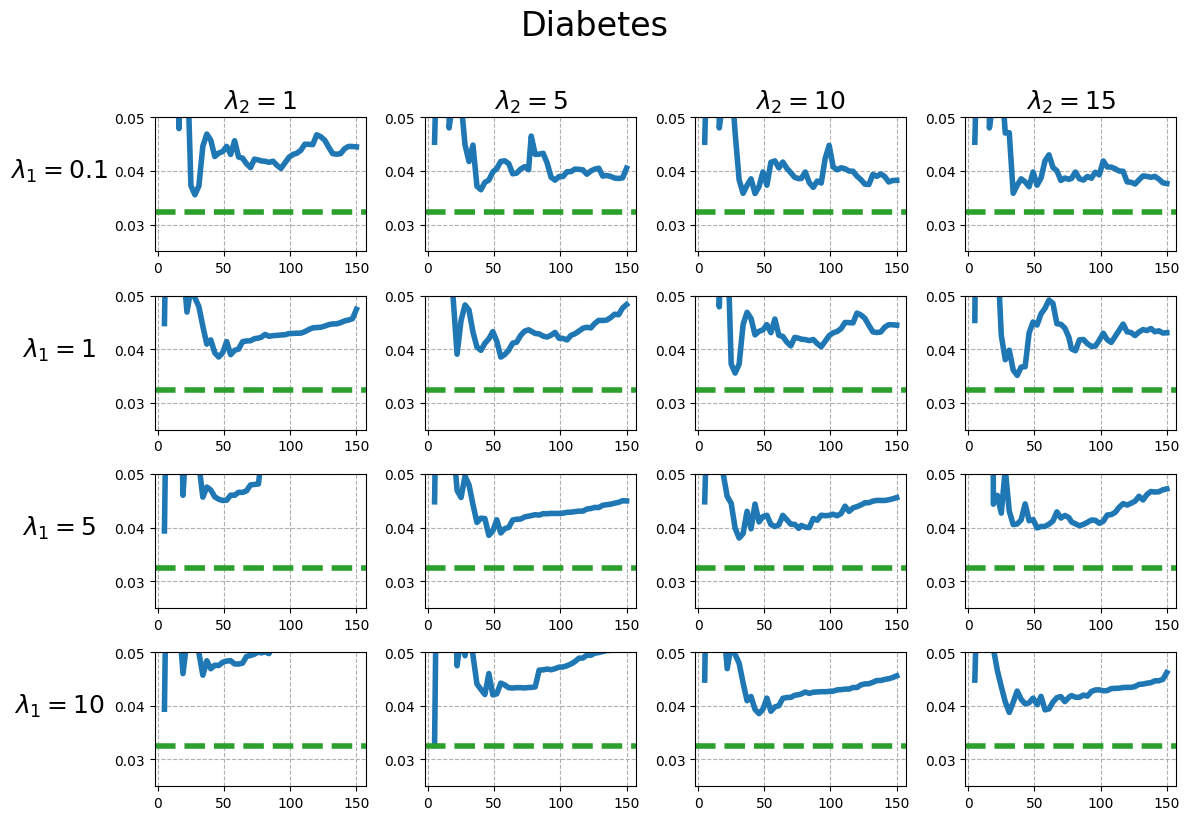

In [211]:
subset_range = [int(x) for x in np.linspace(5, 150, 50)]

baseline = fit_predict(diabetes_seller_x, diabetes_seller_y, diabetes_test_x, diabetes_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(12, 8))

fig.suptitle('Diabetes', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = diabetes_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(0.025, 0.05)
        ax[i][j].grid(True, ls='--')
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig(figure_dir / 'lambda-diabetes.png', bbox_inches='tight')

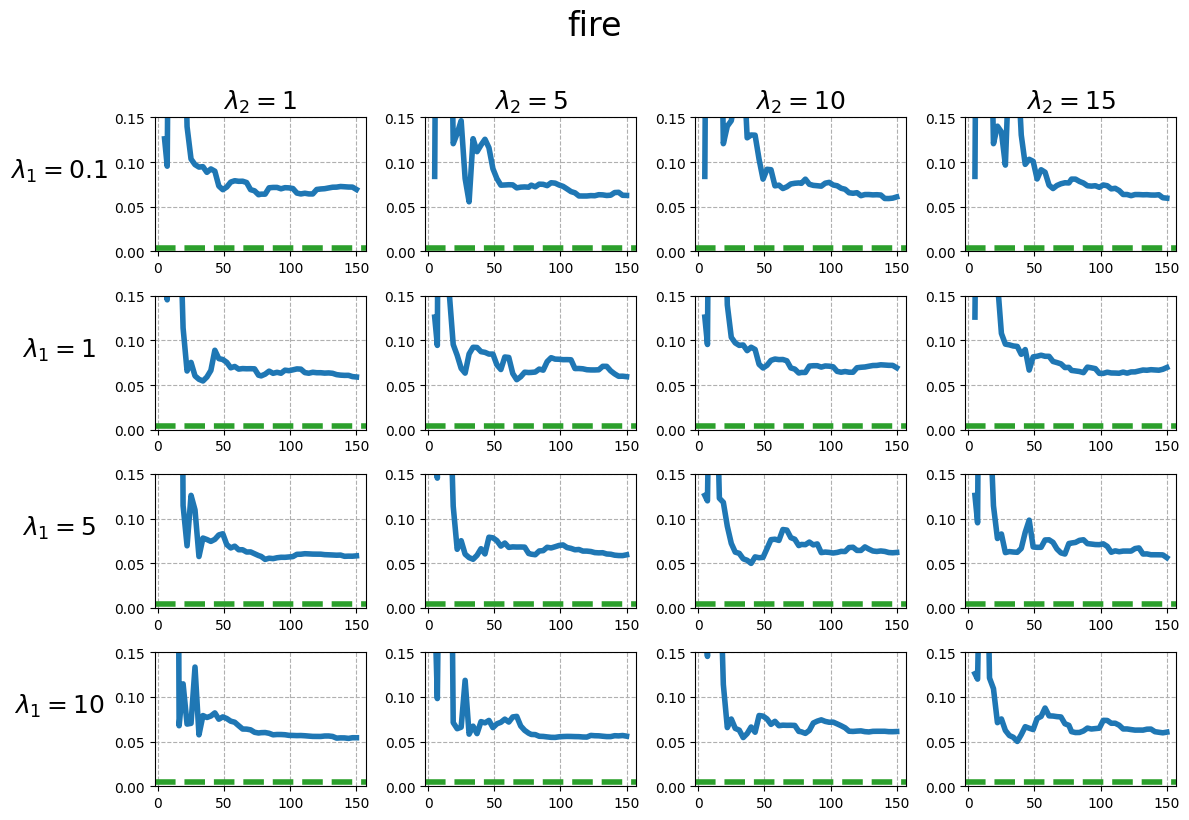

In [215]:

baseline = fit_predict(fire_seller_x, fire_seller_y, fire_test_x, fire_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(12, 8))

fig.suptitle('fire', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = fire_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(0, 0.15)
        ax[i][j].grid(True, ls='--')
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig(figure_dir / 'lambda-fire.png', bbox_inches='tight')

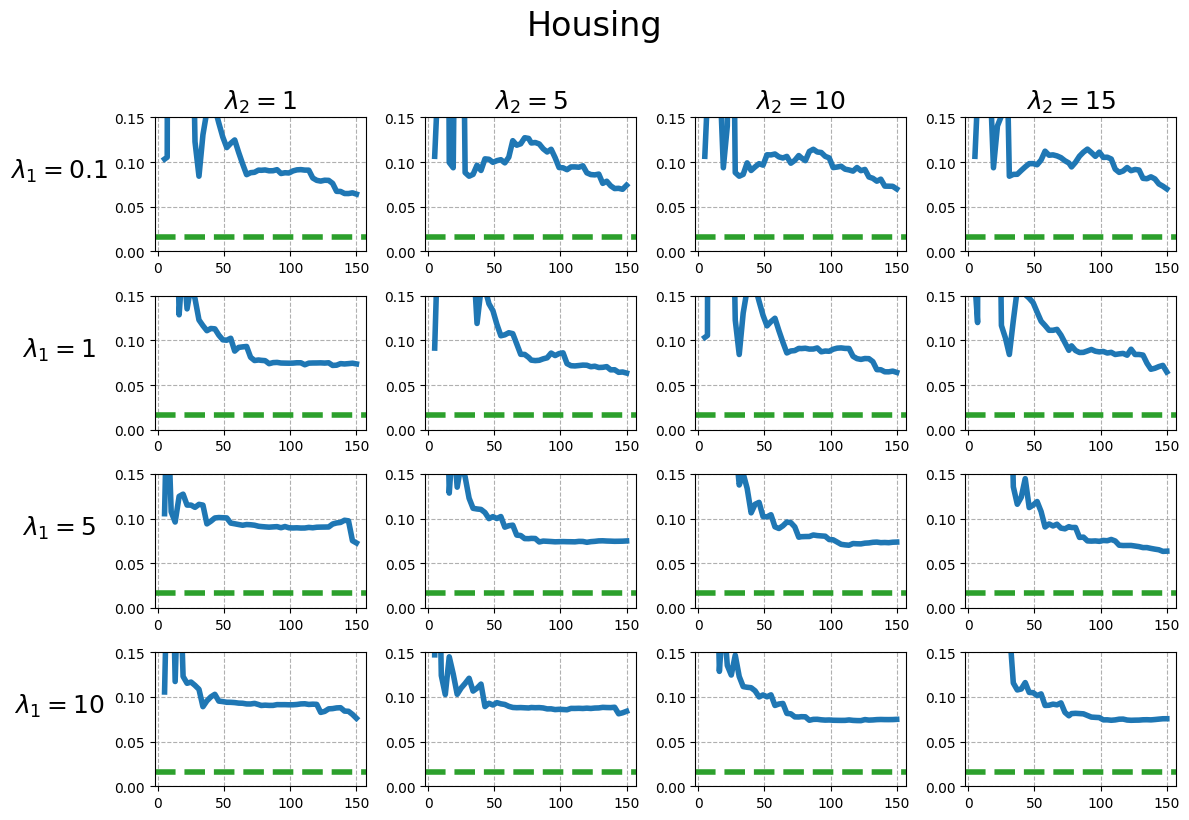

In [212]:

baseline = fit_predict(housing_seller_x, housing_seller_y, housing_test_x, housing_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(12, 8))

fig.suptitle('Housing', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = housing_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(0, 0.15)
        ax[i][j].grid(True, ls='--')
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig(figure_dir / 'lambda-housing.png', bbox_inches='tight')

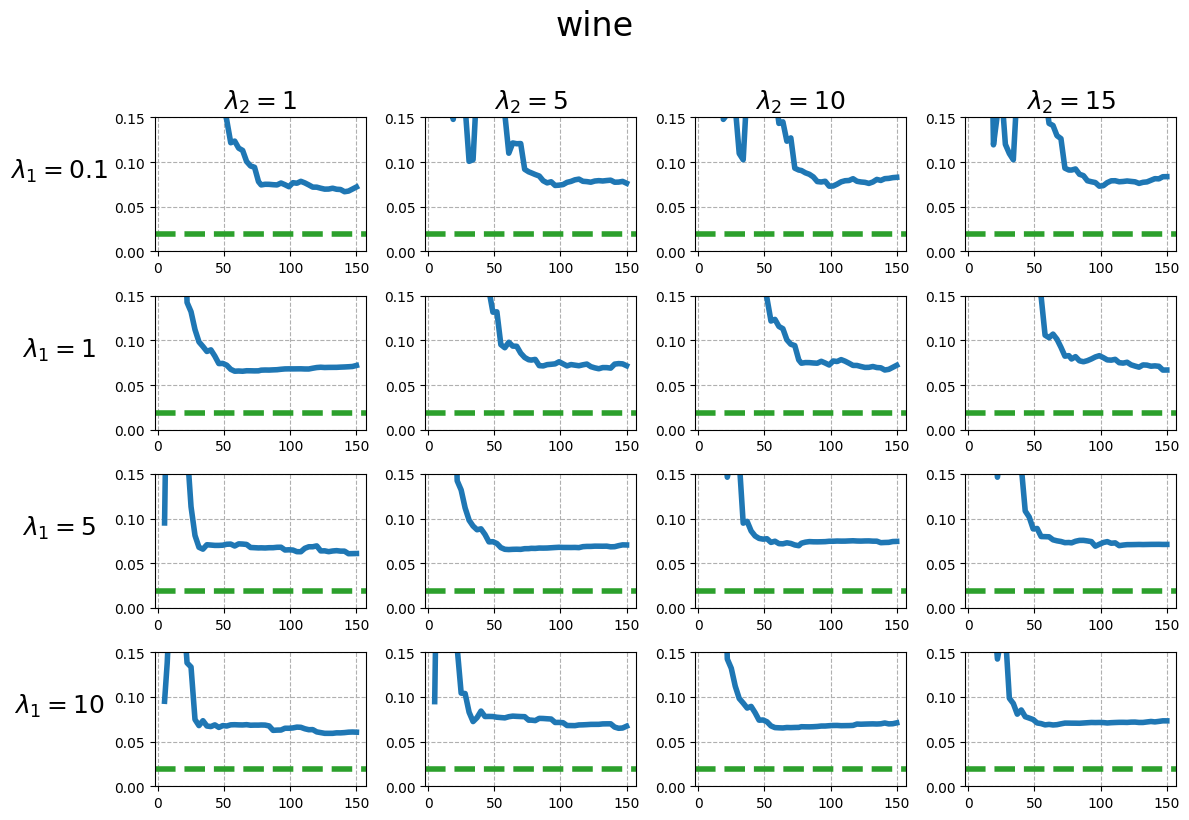

In [213]:

baseline = fit_predict(wine_seller_x, wine_seller_y, wine_test_x, wine_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(12, 8))

fig.suptitle('wine', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = wine_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(0, 0.15)
        ax[i][j].grid(True, ls='--')
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig(figure_dir / 'lambda-wine.png', bbox_inches='tight')

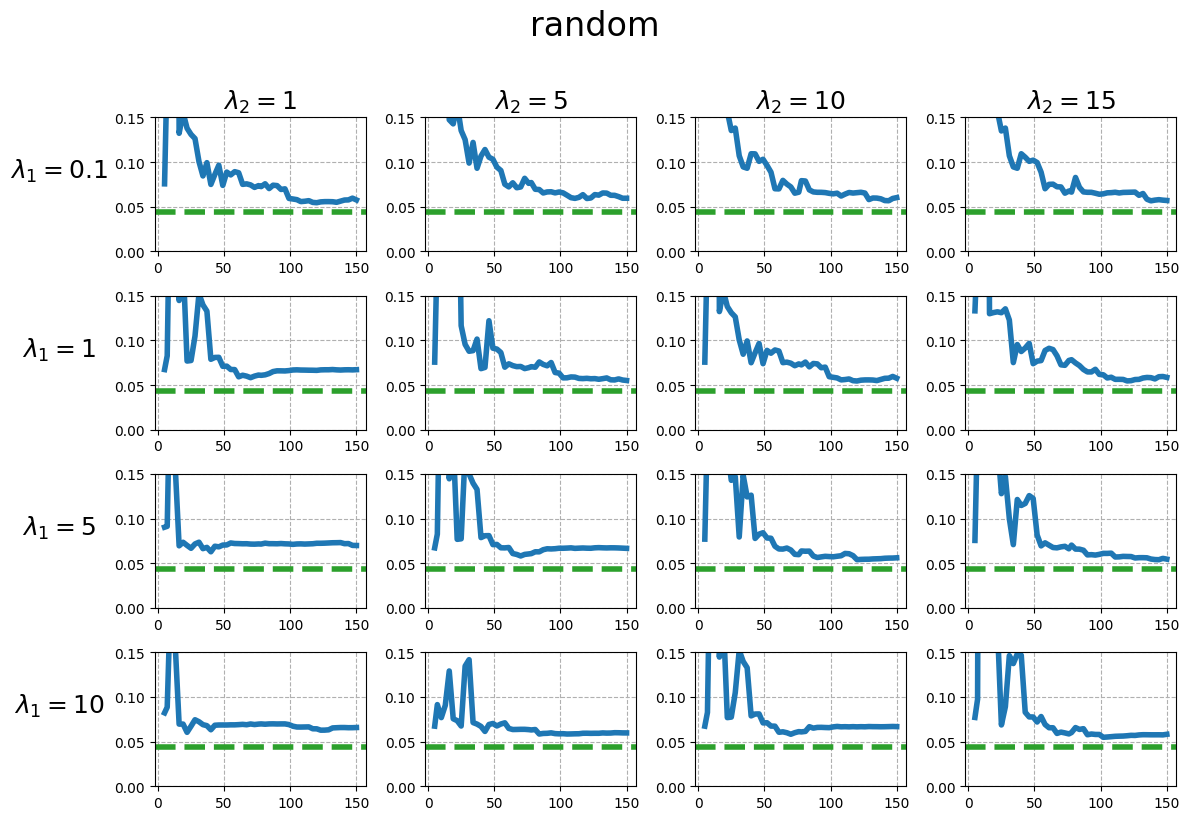

In [214]:
baseline = fit_predict(random_seller_x, random_seller_y, random_test_x, random_test_y)

fig, ax = plt.subplots(nrows=len(lambda_1_range), ncols=len(lambda_2_range), figsize=(12, 8))

fig.suptitle('random', fontsize=24, y=1.02)
           
for i, lam1 in enumerate(lambda_1_range):
    for j, lam2 in enumerate(lambda_2_range):
        results = []
        weights = random_lambda_weights[lam1][lam2]
        for num_selected in subset_range:
            indices = weights.argsort()[:-num_selected:-1]
            results.append(fit_predict(seller_data_x[indices], seller_data_y[indices], diabetes_test_x, diabetes_test_y))
        ax[i][j].plot(subset_range, results, lw=4)
        ax[i][j].axhline(baseline, ls='--', label='baseline', lw=4, c='C2')
        ax[i][j].set_ylim(0, 0.15)
        ax[i][j].grid(True, ls='--')
        
        if i == 0:
            ax[i][j].set_title(fr'$\lambda_2=${lambda_2_range[j]}', fontsize=18)
            
        if j == 0:
            ax[i][j].set_ylabel(fr'$\lambda_1=${lambda_1_range[i]}', fontsize=18, rotation=0, labelpad=40)
        
fig.set_tight_layout(True)
plt.savefig(figure_dir / 'lambda-random.png', bbox_inches='tight')

### same P(Y|X), different features

In [745]:
with open('temp.txt', 'a') as fp:
    print('asdf', file=fp)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [974]:
np.concatenate([test_x[:, [2]], np.zeros_like(test_x)[:, 1:8]], axis=1).shape

(142, 8)

In [1017]:

np.pad(sell_x[:100, :6],  ((0, 0), (0, 2))).shape

(100, 8)

In [1024]:
_x = np.np.pad(sell_x[:100, :6],  ((0, 0), (0, 1)))
# _x = sell_x[:50, :2]
np.linalg.inv(_x.T @ _x)

LinAlgError: Singular matrix

In [ ]:
# dataset = 'diabetes'
dataset = 'housing'
num_trials = 10

if dataset == 'diabetes':
    data = load_diabetes()
    x = data["data"]
    y = data["target"]
elif dataset == 'housing':
    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    housing_df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
    exclude = ['CHAS']
    housing_df = housing_df.drop(columns=exclude)
    x = housing_df.iloc[:, :12].values
    y = housing_df.MEDV.values
    

MMS = MinMaxScaler()
scaled_x = MMS.fit_transform(x)
scaled_y = MMS.fit_transform(y[:, None]).flatten()

trial_buyer1_errors = defaultdict(list)
trial_buyer2_errors = defaultdict(list)
trial_buyer3_errors = defaultdict(list)
trial_buyer4_errors = defaultdict(list)

trial_buyer1_baselines = defaultdict(list)
trial_buyer2_baselines = defaultdict(list)
trial_buyer3_baselines = defaultdict(list)
trial_buyer4_baselines = defaultdict(list)

for trial in range(num_trials):
    train_x, test_x, train_y, test_y = train_test_split(scaled_x, scaled_y, test_size=0.32, random_state=trial)
    sell_x, buy_x, sell_y, buy_y = train_test_split(train_x, train_y, test_size=0.333, random_state=trial)
    
    if dataset == 'diabetes':
        x_sell = np.concatenate([
            np.pad(sell_x[:40,      :2],  ((0, 0), (0, 8))),
            np.pad(sell_x[40:80,   2:4],  ((0, 0), (2, 6))),
            np.pad(sell_x[80:120,  4:6],  ((0, 0), (4, 4))),
            np.pad(sell_x[120:160, 6:8],  ((0, 0), (6, 2))),
            np.pad(sell_x[160:,   8:10], ((0, 0), (8, 0))),
        ])
        y_sell = sell_y

        x_buyer1 = np.pad(buy_x[:, :2], ((0, 0), (0, 8)))
        x_buyer2 = np.pad(buy_x[:, :3], ((0, 0), (0, 7)))
        x_buyer3 = np.pad(buy_x[:, :4], ((0, 0), (0, 6)))
        x_buyer4 = buy_x

        x_test1  = np.pad(test_x[:, :2], ((0, 0), (0, 8))) 
        x_test2  = np.pad(test_x[:, :3], ((0, 0), (0, 7))) 
        x_test3  = np.pad(test_x[:, :4], ((0, 0), (0, 6))) 
        x_test4  = test_x
    elif dataset == 'housing':
        x_sell = np.concatenate([
            np.pad(sell_x[:50,      :6],   ((0, 0), (0, 6))),
            np.pad(sell_x[50:100,  2:8],   ((0, 0), (2, 4))),
            np.pad(sell_x[100:150, 4:10],  ((0, 0), (4, 2))),
            np.pad(sell_x[150:200, 6:12],  ((0, 0), (6, 0))),
        ])
        y_sell = sell_y

#         x_buyer1 = np.pad(buy_x[:, :4], ((0, 0), (0, 8)))
#         x_buyer2 = np.pad(buy_x[:, 2:6], ((0, 0), (2, 6)))
#         x_buyer3 = np.pad(buy_x[:, 4:8], ((0, 0), (4, 4)))
#         x_buyer4 = np.pad(buy_x[:, 6:10], ((0, 0), (6, 2)))
        
#         x_test1 = np.pad(test_x[:, :4], ((0, 0), (0, 8)))
#         x_test2 = np.pad(test_x[:, 2:6], ((0, 0), (2, 6)))
#         x_test3 = np.pad(test_x[:, 4:8], ((0, 0), (4, 4)))
#         x_test4 = np.pad(test_x[:, 6:10], ((0, 0), (6, 2)))
        
        zeros = np.zeros_like(buy_x)
        x_buyer1  = np.pad(buy_x[:, :3], ((0, 0), (0, 9))) 
        x_buyer2  = np.concatenate([buy_x[:, [0]], zeros[:, 1:3], buy_x[:, [4]], zeros[:, 4:]], axis=1)
        x_buyer3  = np.concatenate([buy_x[:, [0]], zeros[:, 1:9], buy_x[:, [10]], zeros[:, 10:]], axis=1)
        x_buyer4  = np.concatenate([buy_x[:, [0]], zeros[:, 1:11], buy_x[:, [11]]], axis=1)
        assert zeros.shape == x_buyer1.shape == x_buyer2.shape == x_buyer3.shape == x_buyer4.shape

        zeros = np.zeros_like(test_x)
        x_test1  = np.pad(test_x[:, :3], ((0, 0), (0, 9))) 
        x_test2  = np.concatenate([test_x[:, [0]], zeros[:, 1:3], test_x[:, [4]], zeros[:, 4:]], axis=1)
        x_test3  = np.concatenate([test_x[:, [0]], zeros[:, 1:9], test_x[:, [10]], zeros[:, 10:]], axis=1)
        x_test4  = np.concatenate([test_x[:, [0]], zeros[:, 1:11], test_x[:, [11]]], axis=1)
        assert zeros.shape == x_test1.shape == x_test2.shape == x_test3.shape == x_test4.shape

    y_buyer = buy_y
    y_test = test_y
    
    buyer1_weights = {}
    buyer2_weights = {}
    buyer3_weights = {}
    buyer4_weights = {}

    # for k in tqdm(np.arange(1, 20, 1)):
    # for k in tqdm(np.arange(1, 30, 5)):
    for k in tqdm([1, 5, 15, 50]):
        print('\t', str(k).center(20, '-'))
        # if k == 0:
            # k = 1
        print('    buyer 1', end='\t')
        buyer1_weights[k] = optimize_seller_weights(x_sell, x_buyer1[:k])
        print('    buyer 2', end='\t')
        buyer2_weights[k] = optimize_seller_weights(x_sell, x_buyer2[:k])
        print('    buyer 3', end='\t')
        buyer3_weights[k] = optimize_seller_weights(x_sell, x_buyer3[:k])
        print('    buyer 4', end='\t')
        buyer4_weights[k] = optimize_seller_weights(x_sell, x_buyer4[:k])
        
    train_range = np.arange(2, x_sell.shape[0])
    
    np.random.seed(trial)
    random_index = np.random.permutation(np.arange(x_sell.shape[0]))
                                   
    trial_buyer1_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test1, y_test) for num_train in train_range
    ])
    trial_buyer2_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test2, y_test) for num_train in train_range
    ])
    trial_buyer3_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test3, y_test) for num_train in train_range
    ])
    trial_buyer4_baselines['seller'].append([
        fit_predict(x_sell[random_index][:num_train], y_sell[random_index][:num_train], x_test4, y_test) for num_train in train_range
    ])
    
    trial_buyer1_baselines['buyer'].append([
        fit_predict(x_buyer1[:num_train], y_buyer[:num_train], x_test1, y_test) for num_train in train_range
    ])
    trial_buyer2_baselines['buyer'].append([
        fit_predict(x_buyer2[:num_train], y_buyer[:num_train], x_test2, y_test) for num_train in train_range
    ])
    trial_buyer3_baselines['buyer'].append([
        fit_predict(x_buyer3[:num_train], y_buyer[:num_train], x_test3, y_test) for num_train in train_range
    ])
    trial_buyer4_baselines['buyer'].append([
        fit_predict(x_buyer4[:num_train], y_buyer[:num_train], x_test4, y_test) for num_train in train_range
    ])
                                   
    for num_buy, w in buyer1_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer1_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test1, y_test,
            ) for num_train in train_range
        ])

    for num_buy, w in buyer2_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer2_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test2, y_test,
            ) for num_train in train_range
        ])

    for num_buy, w in buyer3_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer3_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test3, y_test,
            ) for num_train in train_range
        ])

    for num_buy, w in buyer4_weights.items():
        sorted_weight_index = w.argsort()
        trial_buyer4_errors[num_buy].append([
            fit_predict(
                x_sell[sorted_weight_index[:-num_train:-1]], 
                y_sell[sorted_weight_index[:-num_train:-1]], 
                x_test4, y_test,
            ) for num_train in train_range
        ])

    print(f' {trial=} done '.center(40, '#'))

  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 2.2	prob.value=0.69
    buyer 2	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.3	prob.value=2.05
    buyer 3	optimal 3.5	prob.value=4.01
    buyer 4	optimal 2.5	prob.value=1.55
	 ---------5----------
    buyer 1	optimal_inaccurate 8.1	prob.value=1.85
    buyer 2	optimal_inaccurate 8.1	prob.value=2.64
    buyer 3	optimal_inaccurate 9.4	prob.value=6.91
    buyer 4	optimal_inaccurate 7.9	prob.value=1.56
	 ---------15---------
    buyer 1	optimal_inaccurate 12.8	prob.value=1.67
    buyer 2	optimal_inaccurate 12.6	prob.value=2.76
    buyer 3	optimal_inaccurate 13.5	prob.value=5.79
    buyer 4	optimal_inaccurate 14.5	prob.value=0.93
	 ---------50---------
    buyer 1	optimal_inaccurate 54.1	prob.value=4.32
    buyer 2	optimal_inaccurate 60.4	prob.value=6.75
    buyer 3	optimal_inaccurate 57.5	prob.value=26.61
    buyer 4	optimal_inaccurate 52.7	prob.value=13.65
############# trial=0 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 1.2	prob.value=0.87
    buyer 2	optimal 2.8	prob.value=2.18
    buyer 3	optimal 1.5	prob.value=5.24
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.8	prob.value=2.33
	 ---------5----------
    buyer 1	optimal 6.7	prob.value=2.65
    buyer 2	optimal 4.5	prob.value=2.54
    buyer 3	optimal 2.7	prob.value=5.84
    buyer 4	optimal 7.6	prob.value=3.96
	 ---------15---------
    buyer 1	optimal 10.0	prob.value=3.65
    buyer 2	optimal_inaccurate 13.0	prob.value=3.18
    buyer 3	optimal 6.8	prob.value=5.81
    buyer 4	optimal_inaccurate 11.7	prob.value=3.50
	 ---------50---------
    buyer 1	optimal_inaccurate 57.3	prob.value=4.07
    buyer 2	optimal_inaccurate 65.8	prob.value=2.77
    buyer 3	optimal 35.0	prob.value=5.36
    buyer 4	optimal_inaccurate 58.6	prob.value=2.76
############# trial=1 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 0.7	prob.value=3.18
    buyer 2	optimal 0.9	prob.value=1.13
    buyer 3	optimal 3.4	prob.value=5.99
    buyer 4	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.3	prob.value=1.46
	 ---------5----------
    buyer 1	optimal_inaccurate 9.4	prob.value=3.00
    buyer 2	optimal 7.1	prob.value=5.27
    buyer 3	optimal_inaccurate 9.1	prob.value=6.40
    buyer 4	optimal_inaccurate 9.1	prob.value=1.52
	 ---------15---------
    buyer 1	optimal_inaccurate 14.2	prob.value=2.18
    buyer 2	optimal_inaccurate 14.6	prob.value=5.00
    buyer 3	optimal_inaccurate 12.4	prob.value=5.62
    buyer 4	optimal_inaccurate 12.3	prob.value=1.04
	 ---------50---------
    buyer 1	optimal_inaccurate 54.1	prob.value=3.09
    buyer 2	optimal_inaccurate 57.0	prob.value=1.68
    buyer 3	optimal_inaccurate 54.1	prob.value=4.41
    buyer 4	optimal_inaccurate 47.3	prob.value=1.74
############# trial=2 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 1.0	prob.value=2.63
    buyer 2	optimal 0.6	prob.value=2.01
    buyer 3	optimal 1.4	prob.value=3.79
    buyer 4	optimal 1.0	prob.value=2.11
	 ---------5----------
    buyer 1	optimal 3.6	prob.value=1.30
    buyer 2	optimal 1.5	prob.value=2.78
    buyer 3	optimal 5.5	prob.value=4.79
    buyer 4	optimal 2.7	prob.value=0.70
	 ---------15---------
    buyer 1	optimal 7.9	prob.value=2.09
    buyer 2	optimal 5.3	prob.value=2.57
    buyer 3	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 12.8	prob.value=4.42
    buyer 4	optimal 3.6	prob.value=0.71
	 ---------50---------
    buyer 1	optimal_inaccurate 54.1	prob.value=2.59
    buyer 2	optimal 22.0	prob.value=2.92
    buyer 3	optimal 52.7	prob.value=4.98
    buyer 4	optimal 46.4	prob.value=0.99
############# trial=3 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 1.1	prob.value=0.57
    buyer 2	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 6.7	prob.value=5.38
    buyer 3	optimal 4.0	prob.value=5.17
    buyer 4	optimal 6.2	prob.value=1.60
	 ---------5----------
    buyer 1	optimal_inaccurate 8.1	prob.value=5.20
    buyer 2	optimal_inaccurate 7.7	prob.value=3.63
    buyer 3	optimal_inaccurate 8.3	prob.value=6.38
    buyer 4	optimal_inaccurate 7.9	prob.value=8.67
	 ---------15---------
    buyer 1	optimal_inaccurate 11.4	prob.value=4.17
    buyer 2	optimal_inaccurate 11.9	prob.value=5.01
    buyer 3	optimal_inaccurate 13.0	prob.value=6.74
    buyer 4	optimal_inaccurate 11.2	prob.value=15.58
	 ---------50---------
    buyer 1	optimal_inaccurate 50.0	prob.value=6.35
    buyer 2	optimal_inaccurate 53.7	prob.value=6.68
    buyer 3	optimal_inaccurate 51.4	prob.value=43.19
    buyer 4	optimal_inaccurate 47.0	prob.value=-475.36
############# trial=4 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 1.4	prob.value=5.21
    buyer 2	optimal 1.8	prob.value=5.70
    buyer 3	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 6.1	prob.value=2.09
    buyer 4	optimal_inaccurate 6.1	prob.value=-98.94
	 ---------5----------
    buyer 1	optimal_inaccurate 7.3	prob.value=4.31
    buyer 2	optimal_inaccurate 8.2	prob.value=4.02
    buyer 3	optimal_inaccurate 7.4	prob.value=10.08
    buyer 4	optimal_inaccurate 7.2	prob.value=7.19
	 ---------15---------
    buyer 1	optimal_inaccurate 11.0	prob.value=92.02
    buyer 2	optimal_inaccurate 11.1	prob.value=5.04
    buyer 3	optimal_inaccurate 11.4	prob.value=19.42
    buyer 4	optimal_inaccurate 10.8	prob.value=7.05
	 ---------50---------
    buyer 1	optimal_inaccurate 45.7	prob.value=91.98
    buyer 2	optimal_inaccurate 53.2	prob.value=4.96
    buyer 3	optimal_inaccurate 55.3	prob.value=34.76
    buyer 4	optimal_inaccurate 46.7	prob.value=6.69
############# trial=5 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 0.8	prob.value=0.77
    buyer 2	optimal 1.1	prob.value=1.46
    buyer 3	optimal 4.9	prob.value=4.58
    buyer 4	optimal 2.1	prob.value=1.52
	 ---------5----------
    buyer 1	optimal 7.3	prob.value=2.00
    buyer 2	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.4	prob.value=3.29
    buyer 3	optimal_inaccurate 7.4	prob.value=4.21
    buyer 4	optimal 1.6	prob.value=0.98
	 ---------15---------
    buyer 1	optimal_inaccurate 11.2	prob.value=2.47
    buyer 2	optimal_inaccurate 11.2	prob.value=2.85
    buyer 3	optimal_inaccurate 11.2	prob.value=4.76
    buyer 4	optimal 4.9	prob.value=1.35
	 ---------50---------
    buyer 1	optimal_inaccurate 47.4	prob.value=3.03
    buyer 2	optimal_inaccurate 50.1	prob.value=3.12
    buyer 3	optimal_inaccurate 54.2	prob.value=5.24
    buyer 4	optimal 43.6	prob.value=1.87
############# trial=6 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 0.7	prob.value=0.66
    buyer 2	optimal 1.9	prob.value=3.74
    buyer 3	optimal 1.9	prob.value=4.87
    buyer 4	optimal 3.5	prob.value=0.24
	 ---------5----------
    buyer 1	optimal 3.2	prob.value=1.32
    buyer 2	optimal 5.3	prob.value=2.06
    buyer 3	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.4	prob.value=4.34
    buyer 4	optimal 6.5	prob.value=1.79
	 ---------15---------
    buyer 1	optimal_inaccurate 11.2	prob.value=1.56
    buyer 2	optimal 10.3	prob.value=2.91
    buyer 3	optimal_inaccurate 11.4	prob.value=5.16
    buyer 4	optimal_inaccurate 10.9	prob.value=2.06
	 ---------50---------
    buyer 1	optimal_inaccurate 49.0	prob.value=2.46
    buyer 2	optimal_inaccurate 52.7	prob.value=2.98
    buyer 3	optimal_inaccurate 54.0	prob.value=5.35
    buyer 4	optimal_inaccurate 46.3	prob.value=2.01
############# trial=7 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 1.4	prob.value=1.48
    buyer 2	optimal 1.3	prob.value=1.96
    buyer 3	optimal 5.9	prob.value=5.02
    buyer 4	optimal 1.1	prob.value=0.32
	 ---------5----------
    buyer 1	optimal 4.2	prob.value=1.98
    buyer 2	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.4	prob.value=3.50
    buyer 3	optimal_inaccurate 7.5	prob.value=4.91
    buyer 4	optimal 2.7	prob.value=0.95
	 ---------15---------
    buyer 1	optimal_inaccurate 11.1	prob.value=3.60
    buyer 2	optimal_inaccurate 11.4	prob.value=2.95
    buyer 3	optimal 4.9	prob.value=4.92
    buyer 4	optimal 3.4	prob.value=1.48
	 ---------50---------
    buyer 1	optimal_inaccurate 46.0	prob.value=3.87
    buyer 2	optimal_inaccurate 49.8	prob.value=2.43
    buyer 3	optimal_inaccurate 53.5	prob.value=5.95
    buyer 4	optimal_inaccurate 45.1	prob.value=1.85
############# trial=8 done #############


  0%|          | 0/4 [00:00<?, ?it/s]

	 ---------1----------
    buyer 1	optimal 1.8	prob.value=0.27
    buyer 2	

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal_inaccurate 7.0	prob.value=5.36
    buyer 3	optimal 1.5	prob.value=5.13
    buyer 4	optimal 0.5	prob.value=0.07
	 ---------5----------
    buyer 1	optimal 1.7	prob.value=1.56
    buyer 2	optimal_inaccurate 7.5	prob.value=2.45
    buyer 3	optimal_inaccurate 7.5	prob.value=5.60
    buyer 4	optimal 3.7	prob.value=2.27
	 ---------15---------
    buyer 1	optimal 11.0	prob.value=2.89
    buyer 2	optimal_inaccurate 11.4	prob.value=3.73
    buyer 3	optimal_inaccurate 11.5	prob.value=5.58
    buyer 4	optimal_inaccurate 11.1	prob.value=1.20
	 ---------50---------
    buyer 1	optimal_inaccurate 46.6	prob.value=3.78
    buyer 2	optimal_inaccurate 51.1	prob.value=6.44
    buyer 3	optimal_inaccurate 51.4	prob.value=7.14
    buyer 4	optimal_inaccurate 45.2	prob.value=1.90
############# trial=9 done #############


In [ ]:
colors = np.array(cmap)[np.linspace(0, 255, len(trial_buyer1_errors)).astype(int)]
elinewidth=0.0
errorevery=5
capsize=0

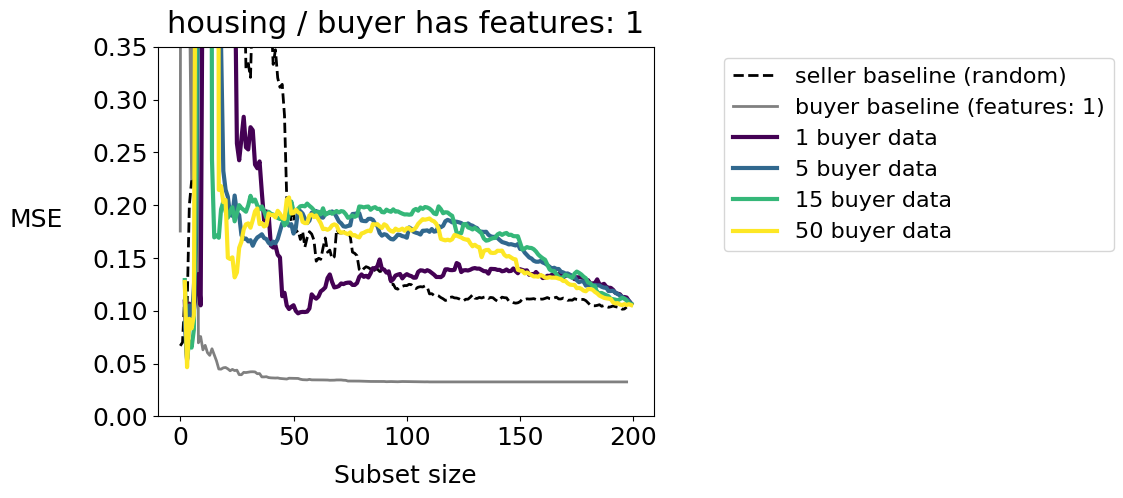

In [ ]:
for i, (k, v) in enumerate(trial_buyer1_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1, 2'
    label = 'buyer baseline (features: 1, 2)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 1'
    label = 'buyer baseline (features: 1)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer1_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (random)')
plt.plot(np.array(trial_buyer1_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.95, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
plt.ylim(0.0, 0.35)
plt.savefig(figure_dir / f'buyer1-{dataset}.png', bbox_inches='tight')

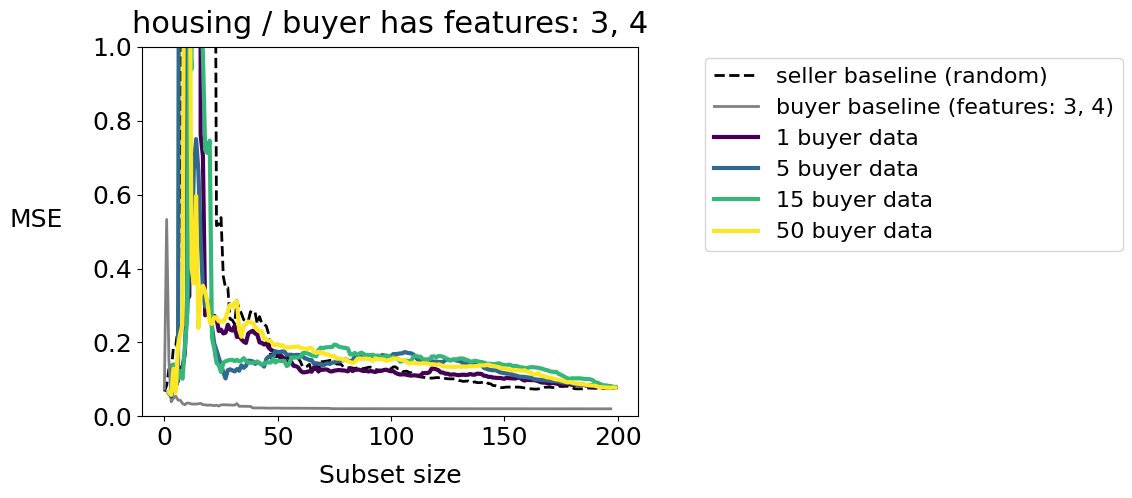

In [ ]:
for i, (k, v) in enumerate(trial_buyer2_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1, 2, 3'
    label = 'buyer baseline (features: 1, 2, 3)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 3, 4'
    label = 'buyer baseline (features: 3, 4)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer2_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (random)')
plt.plot(np.array(trial_buyer2_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(2.00, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
# plt.ylim(0.0, 0.35)
plt.ylim(0.0, 1.)
plt.savefig(figure_dir / f'buyer2-{dataset}.png', bbox_inches='tight')

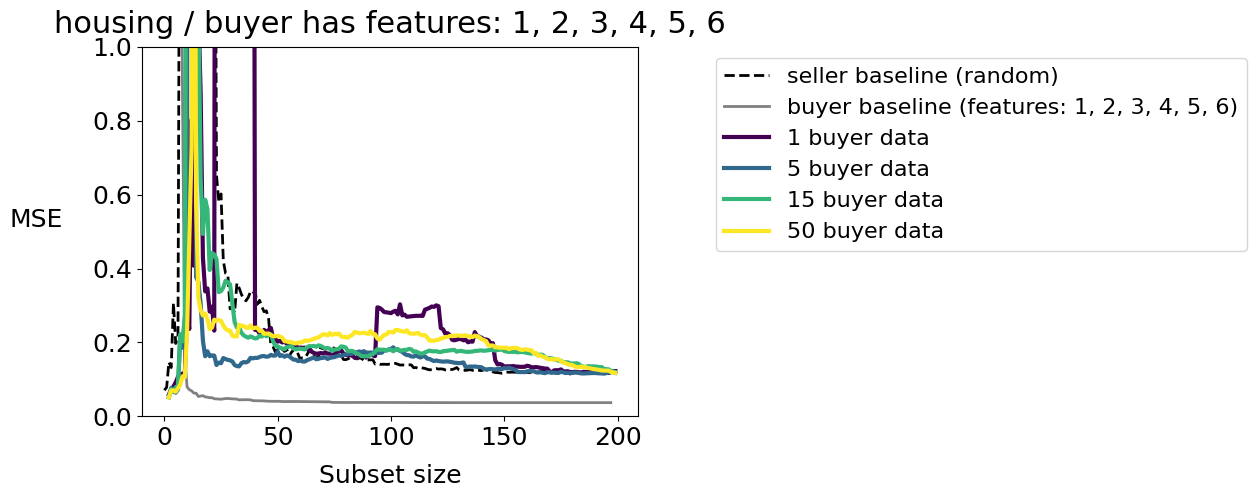

In [ ]:
for i, (k, v) in enumerate(trial_buyer3_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1, 2, 3, 4'
    label = 'buyer baseline (features: 1, 2, 3, 4)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 1, 2, 3, 4, 5, 6'
    label = 'buyer baseline (features: 1, 2, 3, 4, 5, 6)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer3_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (random)')
plt.plot(np.array(trial_buyer3_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(2.25, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
# plt.ylim(0.0, 0.35)
plt.ylim(0.0, 1.)
plt.savefig(figure_dir / f'buyer3-{dataset}.png', bbox_inches='tight')

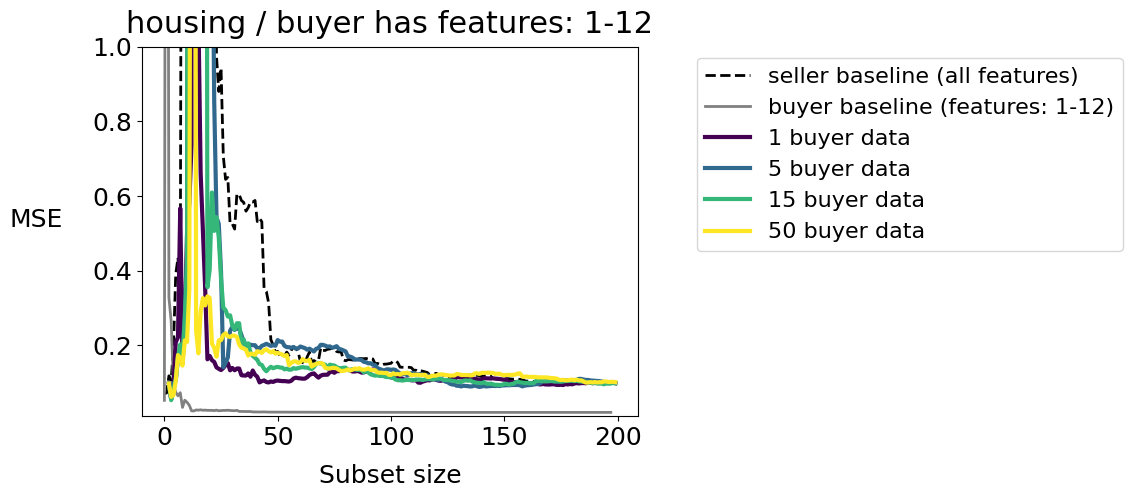

In [ ]:
for i, (k, v) in enumerate(trial_buyer4_errors.items()):
    plt.errorbar(train_range, np.array(v).mean(0), yerr=np.array(v).std(0), lw=3, label=f'{k} buyer data', c=colors[i], elinewidth=elinewidth, capsize=capsize, errorevery=(i, errorevery))
if dataset == 'diabetes':
    title = 'diabetes / buyer has features: 1-10'
    label = 'buyer baseline (features: 1-10)'
elif dataset == 'housing':
    title = 'housing / buyer has features: 1-12'
    label = 'buyer baseline (features: 1-12)'
plt.title(title, fontsize=22, pad=10)
plt.plot(np.array(trial_buyer4_baselines['seller']).mean(0), c='k', lw=2, ls='--', label='seller baseline (all features)')
plt.plot(np.array(trial_buyer4_baselines['buyer']).mean(0), c='gray', lw=2, label=label)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(2.0, 1.00), ncol=1)
plt.xlabel('Subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
plt.tick_params(labelsize=18)
plt.ylim(0.01, 1.0)
plt.savefig(figure_dir / f'buyer4-{dataset}.png', bbox_inches='tight')

In [524]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing_df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

exclude = ['CHAS']
housing_df = housing_df.drop(columns=exclude)
# shuffle_housing_df = housing_df.sample(frac=1, random_state=0)

In [524]:
seller_1_x = MMS.fit_transform(shuffle_housing_df.iloc[:, :2].values)
seller_2_x = MMS.fit_transform(shuffle_housing_df.iloc[:, 2:4].values)
seller_3_x = MMS.fit_transform(shuffle_housing_df.iloc[:, 4:6].values)
seller_4_x = MMS.fit_transform(shuffle_housing_df.iloc[:, 6:8].values)
seller_5_x = MMS.fit_transform(shuffle_housing_df.iloc[:, 8:10].values)
seller_6_x = MMS.fit_transform(shuffle_housing_df.iloc[:, 10:12].values)
seller_y = shuffle_housing_df.MEDV.values

_seller_1_x_train, _seller_1_x_test, _seller_1_x_ref = seller_1_x[:250], seller_1_x[250:400], seller_1_x[400:500]
_seller_2_x_train, _seller_2_x_test, _seller_2_x_ref = seller_2_x[:250], seller_2_x[250:400], seller_2_x[400:500]
_seller_3_x_train, _seller_3_x_test, _seller_3_x_ref = seller_3_x[:250], seller_3_x[250:400], seller_3_x[400:500]
_seller_4_x_train, _seller_4_x_test, _seller_4_x_ref = seller_4_x[:250], seller_4_x[250:400], seller_4_x[400:500]
_seller_5_x_train, _seller_5_x_test, _seller_5_x_ref = seller_5_x[:250], seller_5_x[250:400], seller_5_x[400:500]
_seller_6_x_train, _seller_6_x_test, _seller_6_x_ref = seller_6_x[:250], seller_6_x[250:400], seller_6_x[400:500]
_seller_y_train, _seller_y_test, _seller_y_ref = seller_y[:250], seller_y[250:400], seller_y[400:500]

seller_data_y = np.tile(_seller_y_train, 6)

seller_1_x_train = np.pad(_seller_1_x_train, ((0, 0), (0, 10)))
seller_2_x_train = np.pad(_seller_2_x_train, ((0, 0), (2, 8)))
seller_3_x_train = np.pad(_seller_3_x_train, ((0, 0), (4, 6)))
seller_4_x_train = np.pad(_seller_4_x_train, ((0, 0), (6, 4)))
seller_5_x_train = np.pad(_seller_5_x_train, ((0, 0), (8, 2)))
seller_6_x_train = np.pad(_seller_6_x_train, ((0, 0), (10, 0)))

seller_data_x = np.concatenate([
    seller_1_x_train,
    seller_2_x_train,
    seller_3_x_train,
    seller_4_x_train,
    seller_5_x_train,
    seller_6_x_train,
])

seller_1_x_ref = np.pad(_seller_1_x_ref, ((0, 0), (0, 10)))
seller_2_x_ref = np.pad(_seller_2_x_ref, ((0, 0), (2, 8)))
seller_3_x_ref = np.pad(_seller_3_x_ref, ((0, 0), (4, 6)))
seller_4_x_ref = np.pad(_seller_4_x_ref, ((0, 0), (6, 4)))
seller_5_x_ref = np.pad(_seller_5_x_ref, ((0, 0), (8, 2)))
seller_6_x_ref = np.pad(_seller_6_x_ref, ((0, 0), (10, 0)))

seller_1_x_test = np.pad(_seller_1_x_test, ((0, 0), (0, 10)))
seller_2_x_test = np.pad(_seller_2_x_test, ((0, 0), (2, 8)))
seller_3_x_test = np.pad(_seller_3_x_test, ((0, 0), (4, 6)))
seller_4_x_test = np.pad(_seller_4_x_test, ((0, 0), (6, 4)))
seller_5_x_test = np.pad(_seller_5_x_test, ((0, 0), (8, 2)))
seller_6_x_test = np.pad(_seller_6_x_test, ((0, 0), (10, 0)))

In [542]:
weights = {}

# for k in tqdm(np.arange(1, 20, 1)):
for k in tqdm(np.arange(0, 101, 5)):
    if k == 0:
        k = 1
    weights[k] = optimize_seller_weights(seller_data_x, seller_1_x_ref[:k], lam1=lam1, lam2=lam2)

  0%|          | 0/21 [00:00<?, ?it/s]

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cvxpy/problems/problem.py:161: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


optimal 4.0	prob.value=0.05
optimal 3.1	prob.value=0.02
optimal 3.7	prob.value=0.02
optimal 4.0	prob.value=0.10
optimal 3.9	prob.value=0.11
optimal 3.2	prob.value=0.10
optimal 3.8	prob.value=0.17
optimal 4.0	prob.value=0.16
optimal 3.2	prob.value=0.14
optimal 4.1	prob.value=0.15
optimal 3.9	prob.value=0.14
optimal 4.2	prob.value=0.14
optimal 3.5	prob.value=0.14
optimal 4.2	prob.value=0.15
optimal 4.5	prob.value=0.14
optimal 3.7	prob.value=0.15
optimal 4.2	prob.value=0.16
optimal 4.3	prob.value=0.15
optimal 4.6	prob.value=0.15
optimal 3.8	prob.value=0.16
optimal 4.4	prob.value=0.16


In [537]:
print(fit_predict(seller_1_x_train, _seller_y_train, seller_1_x_test, seller_y_test))
print(fit_predict(seller_2_x_train, _seller_y_train, seller_2_x_test, seller_y_test))
print(fit_predict(seller_3_x_train, _seller_y_train, seller_3_x_test, seller_y_test))
print(fit_predict(seller_4_x_train, _seller_y_train, seller_4_x_test, seller_y_test))
print(fit_predict(seller_5_x_train, _seller_y_train, seller_5_x_test, seller_y_test))
print(fit_predict(seller_6_x_train, _seller_y_train, seller_6_x_test, seller_y_test))

70.08009794473388
68.75855407948762
48.52319970763145
76.28368541463082
60.811163815972236
40.26732404741833


In [588]:
errors = defaultdict(list)
for num_ref, w in weights.items():
    _weights = w.argsort()
    
    for num_train in np.arange(2, 200):
        selected = _weights[:-num_train:-1]
        errors[num_ref].append(fit_predict(seller_data_x[selected], seller_data_y[selected], seller_1_x_test, seller_y_test))

errors = dict(errors)

In [583]:
seller_data_y[_weights[:-40:-1]]

array([32.9,  8.8, 32.2, 35.4, 50. , 23.1, 24.7, 24.5, 20.9, 23.5, 34.6,
       33.3, 19.4, 21.9, 18.9, 24.8, 29. , 22.5, 29.1, 18.6, 24.1, 15. ,
       31.2, 30.5, 37. , 29.8, 10.9, 29.1, 33.2, 17.1, 22. , 26.4, 33.1,
       16.3, 33.4, 23.7, 23.3, 20.1, 22. ])

In [577]:
num_train = 14
fit_predict(seller_data_x[_weights[:-num_train:-1]], seller_data_y[_weights[:-num_train:-1]], seller_1_x_test, seller_y_test)

3435.648670819766

In [552]:
fit_predict(seller_1_x_train[:30], _seller_y_train[:30], seller_1_x_test, seller_y_test)

69.66610432920153

(69.0, 100.0)

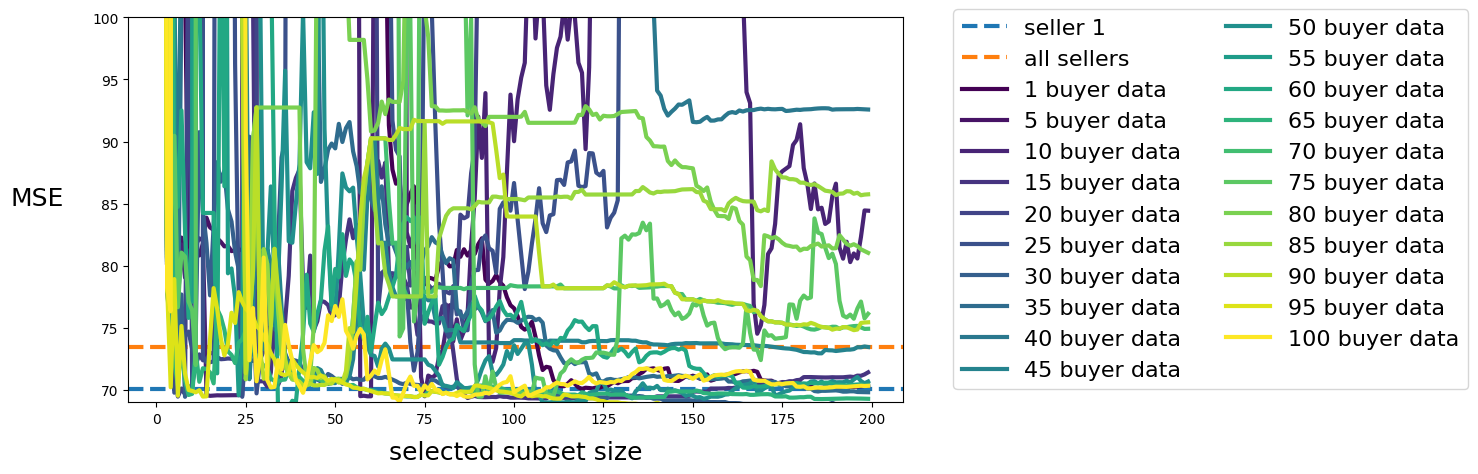

In [595]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, len(errors)).astype(int)]
lw = 4
plt.figure(figsize=(10, 5))
plt.axhline(fit_predict(seller_1_x_train, _seller_y_train, seller_1_x_test, seller_y_test), ls='--', label='seller 1', lw=3, c='C0')
plt.axhline(fit_predict(seller_data_x, seller_data_y, seller_1_x_test, seller_y_test), ls='--', label='all sellers', lw=3, c='C1')
# plt.axhline(random_baseline_diabetes, ls='--', label='baseline: diabetes', lw=lw, c='C1',)
# plt.axhline(random_baseline_fire, ls='--', label='baseline: fire', lw=lw, c='C3',)
# plt.axhline(random_baseline_housing, ls='--', label='baseline: housing', lw=lw, c='C2',)
# plt.axhline(random_baseline_wine, ls='--', label='baseline: wine', lw=lw, c='C4',)
# plt.axhline(random_baseline_random, ls='--', label='baseline: random', lw=lw, c='C7',)
for i, (k, v) in enumerate(errors.items()):
    plt.plot(np.arange(2, 200), v, label=f'{k} buyer data', c=colors[i], lw=3)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.05, 1.05), ncol=2)
# plt.title('Buyer: random', fontsize=24, pad=10)
plt.xlabel('selected subset size', fontsize=18, labelpad=10)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=40)
# plt.yscale('log')
plt.ylim(69, 100)
# plt.tick_params(labelsize=18)
# plt.savefig(figure_dir / 'random.png', bbox_inches='tight')

In [493]:
for k in range(2, 20):
    selected_index = weights[26].argsort()[:-k:-1]
    print(k, fit_predict(seller_data_x[selected_index], seller_data_y[selected_index], seller_1_x_test, seller_y_test))

2 183.38686666666666
3 78.25463634018692
4 76.93476727427607
5 74.4228691280727
6 71.40224146416796
7 69.82106032532528
8 69.79178048365102
9 131.79560295025848
10 125.53947974909266
11 385.4035823476944
12 100.53734908009179
13 233.34997379075537
14 401.7175216304025
15 403.49890012668124
16 490.39982172237
17 493.1285561205482
18 525.1780641252683
19 537.4125825671235


In [ ]:
random_baseline_all = fit_predict(seller_data_x, seller_data_y, random_test_x, random_test_y)
random_baseline_diabetes = fit_predict(diabetes_seller_x, diabetes_seller_y, random_test_x, random_test_y)
random_baseline_fire = fit_predict(fire_seller_x, fire_seller_y, random_test_x, random_test_y)
random_baseline_housing = fit_predict(housing_seller_x, housing_seller_y, random_test_x, random_test_y)
random_baseline_wine = fit_predict(wine_seller_x, wine_seller_y, random_test_x, random_test_y)
random_baseline_random = fit_predict(random_seller_x, random_seller_y, random_test_x, random_test_y)

random_results = defaultdict(list)

for k, v in random_weights.items():
    for num_selected in subset_range:
        indices = v.argsort()[:-num_selected:-1]
        seller_subset_x = seller_data_x[indices]
        seller_subset_y = seller_data_y[indices]
        random_results[k].append(fit_predict(seller_subset_x, seller_subset_y, random_test_x, random_test_y))